In [22]:
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX



**Data Preprocessing using python**

In [23]:
# Input and output paths
input_path = '/content/drive/MyDrive/RAC/RAW/raw.csv'
output_path = '/content/drive/MyDrive/RAC/PROCESSED/'

# Read the dataset
df = pd.read_csv(input_path)

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    industry = row['INDUSTRY']
    industry_data = row[2:]  # Extract the data for the industry, excluding the first two columns

    # Drop all columns named 'Annual'
    industry_data = industry_data.drop(industry_data.filter(like='Annual').index, axis=0)

    # Create a separate DataFrame for the industry
    industry_df = pd.DataFrame(columns=['Time', 'GDP'])

    # Iterate over each quarter in the row
    for i, quarter in enumerate(industry_data):
        quarter_number = i % 4 + 1  # Calculate the quarter number
        year = 1996 + i // 4  # Calculate the year

        # Filter out NaN values
        if not pd.isna(quarter):
            date = pd.Timestamp(year=year, month=(quarter_number - 1) * 3 + 3, day=30)

            # Check if the value is a float or an integer
            if isinstance(quarter, float):
                value = int(quarter)
            else:
                value = str(quarter).replace(',', '')  # Remove any commas in the value

            # Append the values to the industry DataFrame
            industry_df = industry_df.append({'Time': date.strftime('%Y/%m/%d'), 'GDP': value}, ignore_index=True)

    # Save the industry DataFrame to a separate file
    file_name = f"{index+1}. {industry}.csv"
    file_path = os.path.join(output_path, file_name)
    industry_df.to_csv(file_path, index=False)


<ipython-input-23-72b379b5e090>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_df = industry_df.append({'Time': date.strftime('%Y/%m/%d'), 'GDP': value}, ignore_index=True)
<ipython-input-23-72b379b5e090>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_df = industry_df.append({'Time': date.strftime('%Y/%m/%d'), 'GDP': value}, ignore_index=True)
<ipython-input-23-72b379b5e090>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_df = industry_df.append({'Time': date.strftime('%Y/%m/%d'), 'GDP': value}, ignore_index=True)
<ipython-input-23-72b379b5e090>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industr

**Visualizing the extracted data**

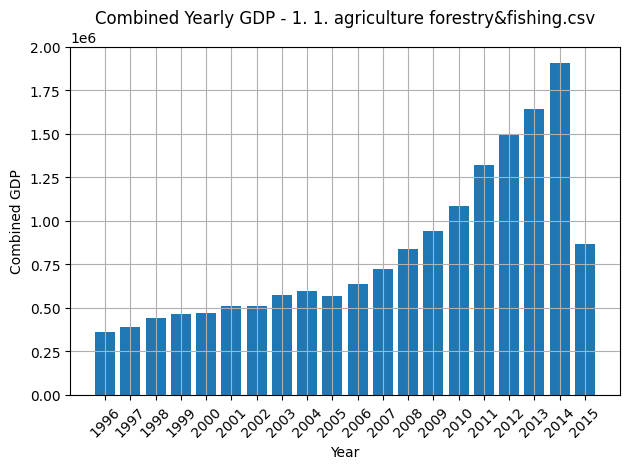

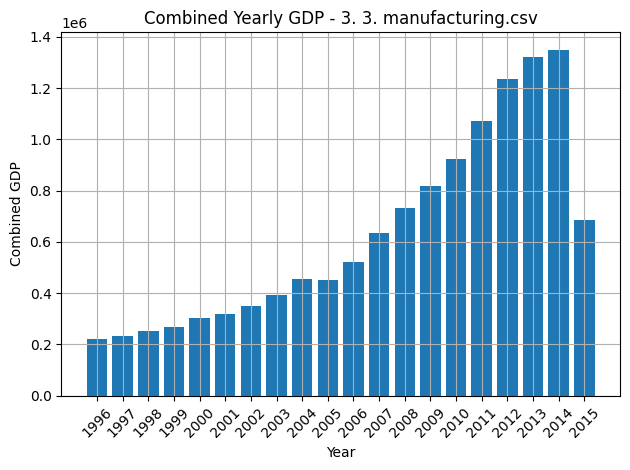

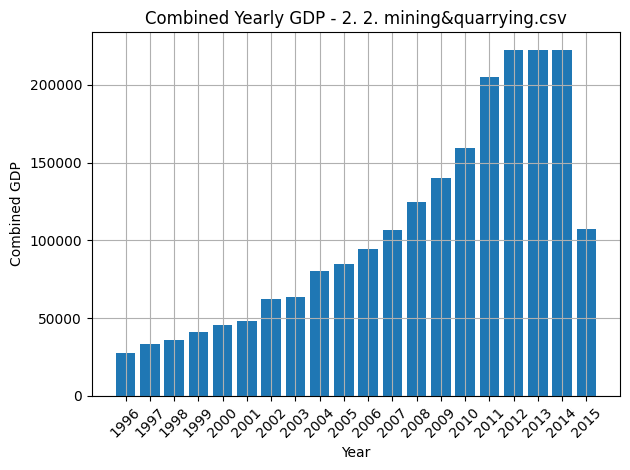

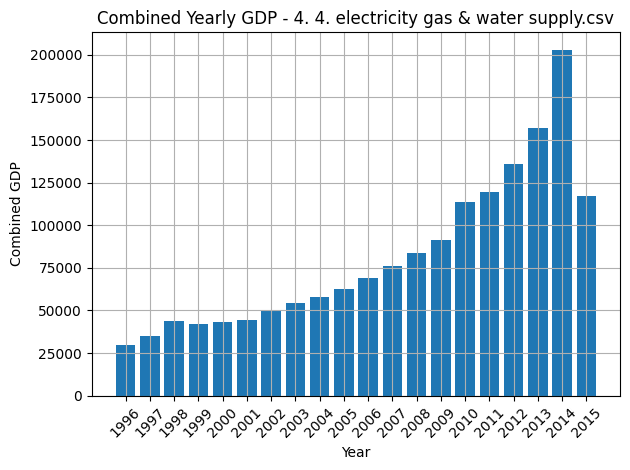

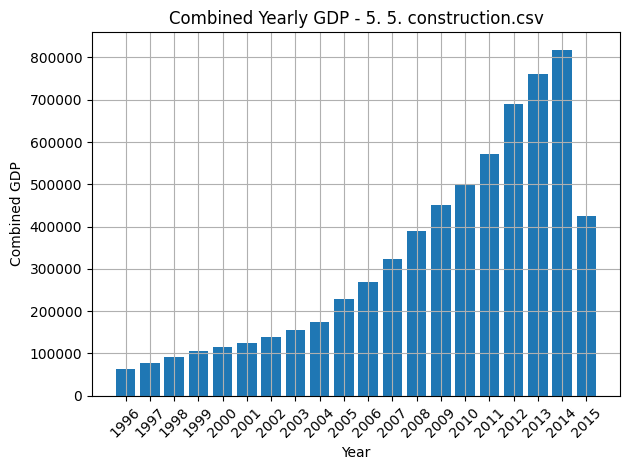

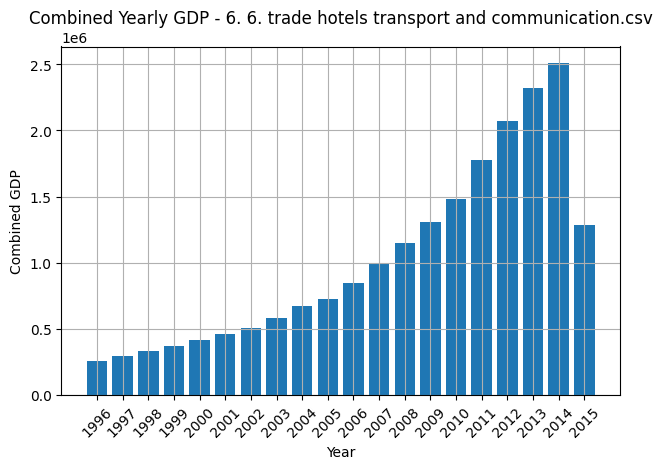

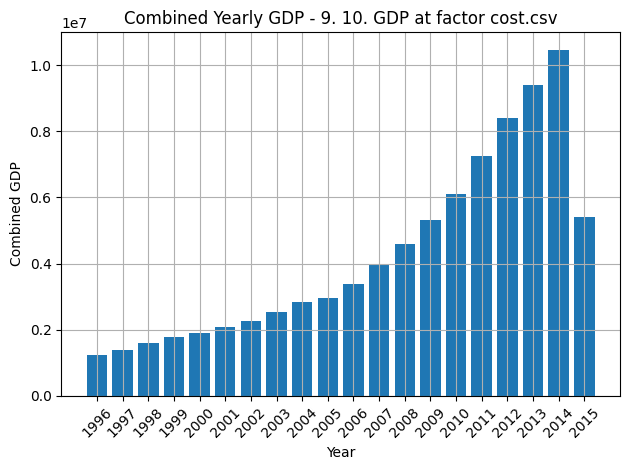

In [ ]:
# Path to the folder containing the CSV files
folder_path = "/content/drive/MyDrive/RAC/PROCESSED"

# Get a list of all CSV files in the folder
csv_files = glob.glob(f"{folder_path}/*.csv")

# Function to process each CSV file and plot the bar graph
def process_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert 'Time' column to datetime
    df['Time'] = pd.to_datetime(df['Time'])

    # Extract the year from the 'Time' column
    df['Year'] = df['Time'].dt.year

    # Group by 'Year' and sum the 'GDP' values for each year
    df_yearly = df.groupby('Year')['GDP'].sum().reset_index()

    # Plot the bar graph
    plt.bar(df_yearly['Year'], df_yearly['GDP'])
    plt.xlabel('Year')
    plt.ylabel('Combined GDP')
    plt.title(f'Combined Yearly GDP - {file_path.split("/")[-1]}')
    plt.xticks(df_yearly['Year'], rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Process each CSV file in the folder
for file_path in csv_files:
    process_csv(file_path)


**Declaring the file paths and respective sectors for the file**

In [ ]:
file_paths = [
               '/content/drive/MyDrive/RAC/PROCESSED/1. 1. agriculture forestry&fishing.csv',
			         '/content/drive/MyDrive/RAC/PROCESSED/2. 2. mining&quarrying.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/3. 3. manufacturing.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/4. 4. electricity gas & water supply.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/5. 5. construction.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/6. 6. trade hotels transport and communication.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/7. 7. financing insurance real estate& business services.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/8. 8. community social & personal services.csv',
               '/content/drive/MyDrive/RAC/PROCESSED/9. 10. GDP at factor cost.csv'
			   ]

sectors = [ 'agriculture forestry&fishing'
            ,'mining&quarrying'
            ,'manufacturing'
            ,'electricity gas & water supply'
            ,'construction'
            ,'trade hotels transport and communication'
            ,'financing insurance real estate& business services'
            ,'community social & personal services'
            ,'GDP at factor cost'  ]



**Propossed ARIMA Model for GDP Forecast**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

Sector: agriculture forestry&fishing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      425335  274292.760346  206482.198235  342103.322457   
1  2011-12-30      368111  268959.732506  200071.479904  337847.985108   
2  2012-03-30      339020  269845.288385  197714.955737  341975.621033   
3  2012-06-30      279526  269698.240735  194887.220708  344509.260761   
4  2012-09-30      480461  269722.658179  192257.985169  347187.331190   
5  2012-12-30      400091  269718.603632  189698.840376  349738.366889   
6  2013-03-30      376012  269719.276895  187221.813412  352216.740377   
7  2013-06-30      307495  269719.165099  184816.552574  354621.777623   
8  2013-09-30      521337  269719.183663  182477.659587  356960.707738   
9  2013-12-30      440082  269719.180580  180199.841099  359238.520061   
10 2014-03-30      423712  269719.181092  177978.563186  361459.798998   
11 2014-06-30      363305  

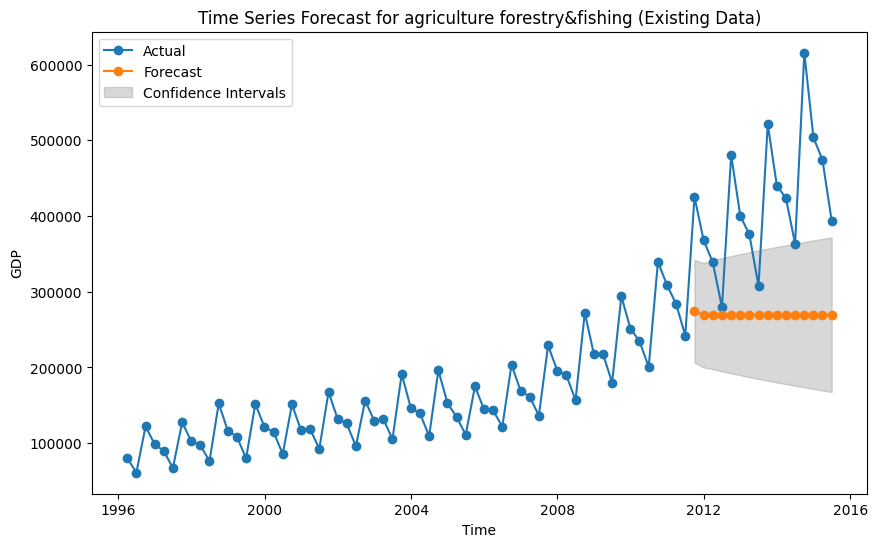

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: mining&quarrying
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP      Lower CI      Upper CI  \
0  2011-09-30       53019   46872.950374  42738.838320  51007.062428   
1  2011-12-30       57369   46869.088301  40346.795249  53391.381354   
2  2012-03-30       51147   46870.085976  38766.283024  54973.888928   
3  2012-06-30       47836   46869.828250  37415.138217  56324.518284   
4  2012-09-30       55985   46869.894828  36241.722672  57498.066983   
5  2012-12-30       67748   46869.877629  35183.804192  58555.951066   
6  2013-03-30       53419   46869.882072  34214.432536  59525.331607   
7  2013-06-30       49830   46869.880924  33314.102722  60425.659126   
8  2013-09-30       56595   46869.881221  32469.979721  61269.782720   
9  2013-12-30       62573   46869.881144  31672.664978  62067.097310   
10 2014-03-30       50724   46869.881164  30915.146762  62824.615566   
11 2014-06-30       51335   46869.881159  30191.999632  63547.7

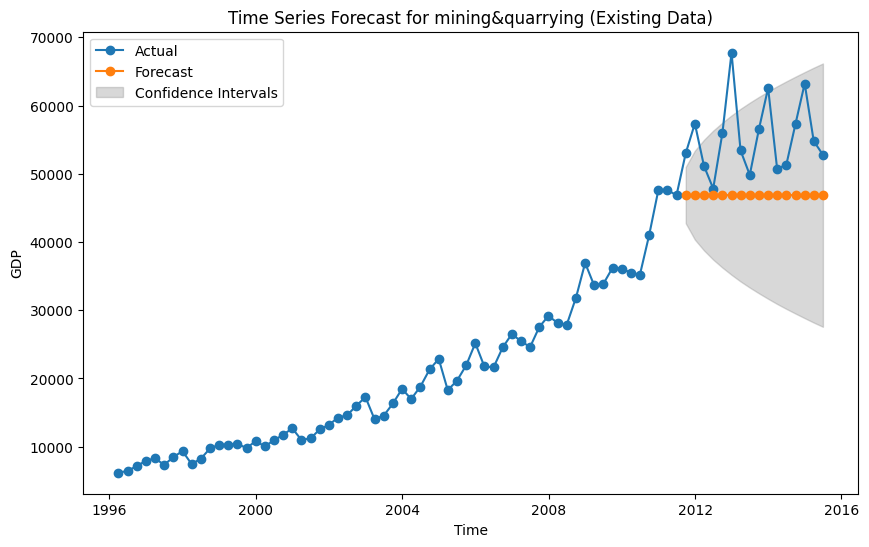

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: manufacturing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      268972  259129.367215  246048.037209  272210.697222   
1  2011-12-30      298844  262362.689151  243747.041206  280978.337097   
2  2012-03-30      300511  265595.965809  242655.524584  288536.407035   
3  2012-06-30      298014  268829.197189  242178.004669  295480.389710   
4  2012-09-30      306048  272062.383292  242085.569113  302039.197471   
5  2012-12-30      331609  275295.524118  242261.689905  308329.358331   
6  2013-03-30      313696  278528.619668  242637.661355  314419.577981   
7  2013-06-30      317223  281761.669943  243169.056296  320354.283591   
8  2013-09-30      331588  284994.674944  243825.251777  326164.098110   
9  2013-12-30      358400  288227.634670  244584.124293  331871.145047   
10 2014-03-30      320159  291460.549123  245429.103424  337491.994822   
11 2014-06-30      329211  294693.418303  

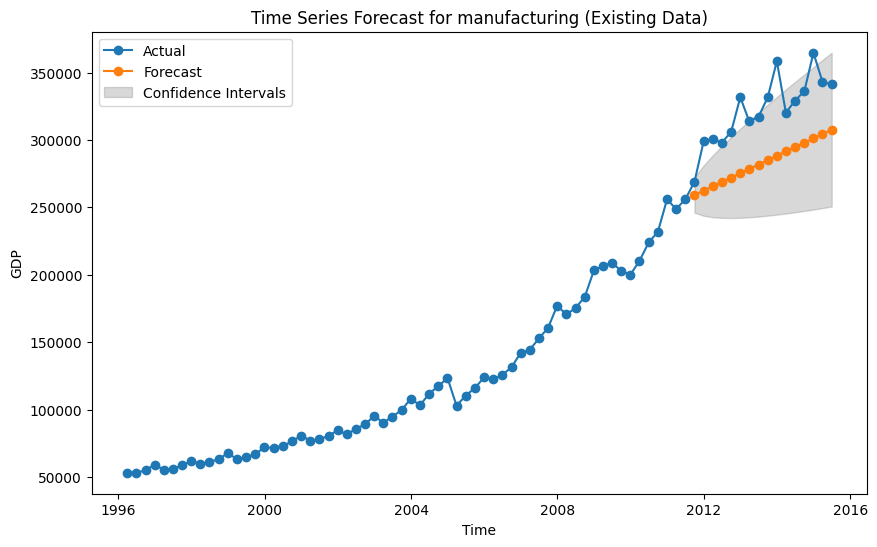

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Sector: electricity gas & water supply
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP      Lower CI      Upper CI  \
0  2011-09-30       29770   29800.016982  28203.079633  31396.954331   
1  2011-12-30       30959   30148.029322  27874.136080  32421.922563   
2  2012-03-30       32906   30496.037019  27692.261947  33299.812091   
3  2012-06-30       33361   30844.040074  27584.912683  34103.167466   
4  2012-09-30       34470   31192.038487  27524.222993  34859.853981   
5  2012-12-30       34933   31540.032258  27496.019152  35584.045364   
6  2013-03-30       37374   31888.021387  27491.950892  36284.091881   
7  2013-06-30       39536   32236.005873  27506.623062  36965.388685   
8  2013-09-30       40175   32583.985718  27536.319932  37631.651504   
9  2013-12-30       40047   32931.960921  27578.359327  38285.562515   
10 2014-03-30       47487   33279.931482  27630.734006  38929.128958   
11 2014-06-30       50529   33627.897401  27691.8

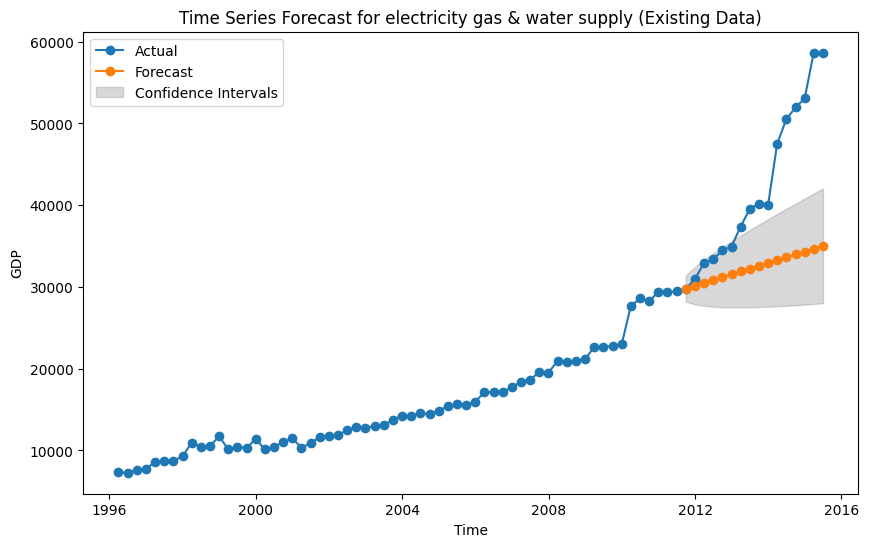

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: construction
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      143525  136495.661364  131251.071608  141740.251120   
1  2011-12-30      159309  138868.397985  131193.088780  146543.707190   
2  2012-03-30      160670  141203.806499  131487.589902  150920.023095   
3  2012-06-30      164722  143502.474154  131919.329491  155085.618816   
4  2012-09-30      175625  145764.978961  132409.340671  159120.617251   
5  2012-12-30      188780  147991.889837  132919.534848  163064.244826   
6  2013-03-30      180261  150183.766750  133428.841456  166938.692044   
7  2013-06-30      177038  152341.160857  133924.631884  170757.689829   
8  2013-09-30      193203  154464.614644  134398.958353  174530.270934   
9  2013-12-30      209488  156554.662063  134846.676577  178262.647549   
10 2014-03-30      190993  158611.828667  135264.418648  181959.238687   
11 2014-06-30      197182  160636.631740  1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

Sector: trade hotels transport and communication
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      447330  428021.967584  406319.013542  449724.921626   
1  2011-12-30      490152  427895.480182  392464.768623  463326.191741   
2  2012-03-30      492924  427901.315066  382918.518874  472884.111259   
3  2012-06-30      499664  427901.045902  375058.712532  480743.379272   
4  2012-09-30      520682  427901.058319  368225.785988  487576.330650   
5  2012-12-30      559002  427901.057746  362098.583306  493703.532186   
6  2013-03-30      544029  427901.057772  356495.224089  499306.891455   
7  2013-06-30      564289  427901.057771  351300.662675  504501.452867   
8  2013-09-30      589596  427901.057771  346436.660801  509365.454741   
9  2013-12-30      626780  427901.057771  341847.147816  513954.967726   
10 2014-03-30      576810  427901.057771  337490.312485  518311.803058   
11 2014-06-30  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: financing insurance real estate& business services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      294757  291003.429335  284784.626895  297222.231775   
1  2011-12-30      310769  298261.103168  288938.746631  307583.459705   
2  2012-03-30      329595  305295.132216  293236.510901  317353.753530   
3  2012-06-30      340147  312112.408080  297455.859648  326768.956511   
4  2012-09-30      349152  318719.609995  301524.534007  335914.685983   
5  2012-12-30      362630  325123.211379  305413.816551  344832.606207   
6  2013-03-30      388606  331329.486169  309112.398034  353546.574304   
7  2013-06-30      399509  337344.514973  312617.154828  362071.875118   
8  2013-09-30      406551  343174.191024  315929.190435  370419.191613   
9  2013-12-30      422410  348824.225956  319051.910303  378596.541608   
10 2014-03-30      461234  354300.155399  321990.001200  386610.309599   
11 20

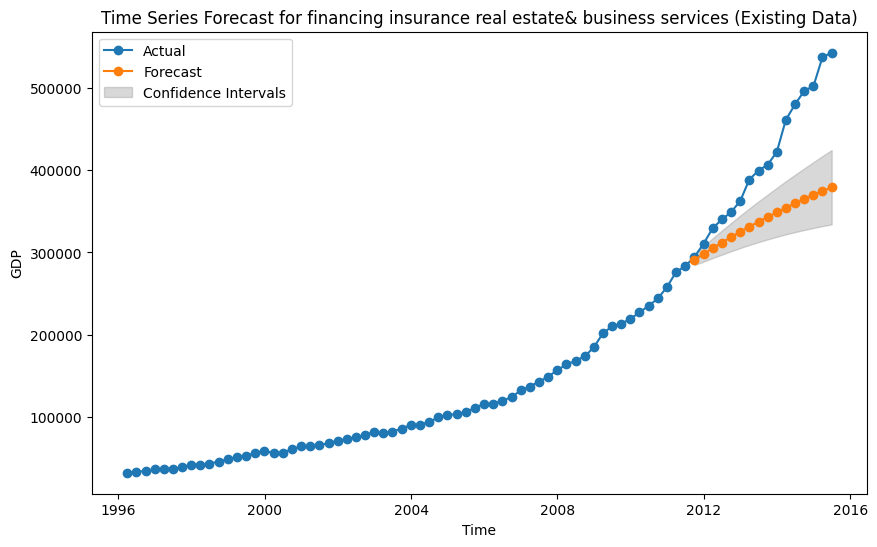

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: community social & personal services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP       Lower CI       Upper CI  \
0  2011-09-30      244011  242009.160140  214449.086792  269569.233488   
1  2011-12-30      297977  257761.451321  220225.736070  295297.166572   
2  2012-03-30      241157  242110.058368  195550.909630  288669.207106   
3  2012-06-30      296508  257661.199377  204578.240036  310744.158718   
4  2012-09-30      279642  242209.668168  182410.826512  302008.509824   
5  2012-12-30      337125  257562.227608  192549.817978  322574.637237   
6  2013-03-30      286490  242308.005993  171710.553109  312905.458876   
7  2013-06-30      351388  257464.519667  182395.419294  332533.620040   
8  2013-09-30      321426  242405.088085  162454.776753  322355.399416   
9  2013-12-30      382431  257368.059415  173439.094074  341297.024756   
10 2014-03-30      339598  242500.930479  154182.990651  330818.870307   
11 2014-06-30      

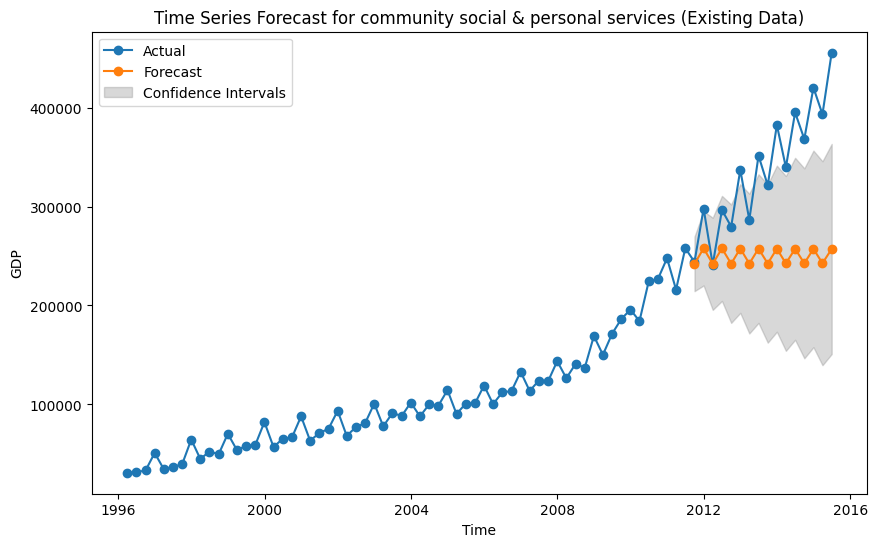

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Sector: GDP at factor cost
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP      Lower CI      Upper CI  \
0  2011-09-30     1906718   1.696735e+06  1.577302e+06  1.816169e+06   
1  2011-12-30     2013488   1.718344e+06  1.548352e+06  1.888337e+06   
2  2012-03-30     1947931   1.739952e+06  1.530431e+06  1.949473e+06   
3  2012-06-30     1959778   1.761558e+06  1.518104e+06  2.005012e+06   
4  2012-09-30     2202066   1.783162e+06  1.509282e+06  2.057041e+06   
5  2012-12-30     2281917   1.804764e+06  1.502904e+06  2.106624e+06   
6  2013-03-30     2179887   1.826364e+06  1.498342e+06  2.154386e+06   
7  2013-06-30     2206307   1.847963e+06  1.495192e+06  2.200734e+06   
8  2013-09-30     2460471   1.869560e+06  1.493173e+06  2.245946e+06   
9  2013-12-30     2542212   1.891155e+06  1.492086e+06  2.290224e+06   
10 2014-03-30     2410718   1.912748e+06  1.491778e+06  2.333718e+06   
11 2014-06-30     2486633   1.934339e+06  1.492133e+06  2.376

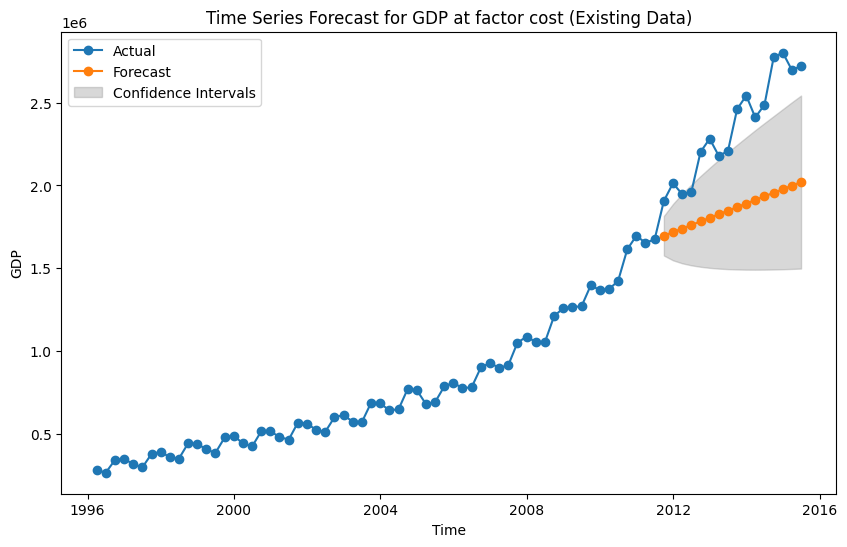

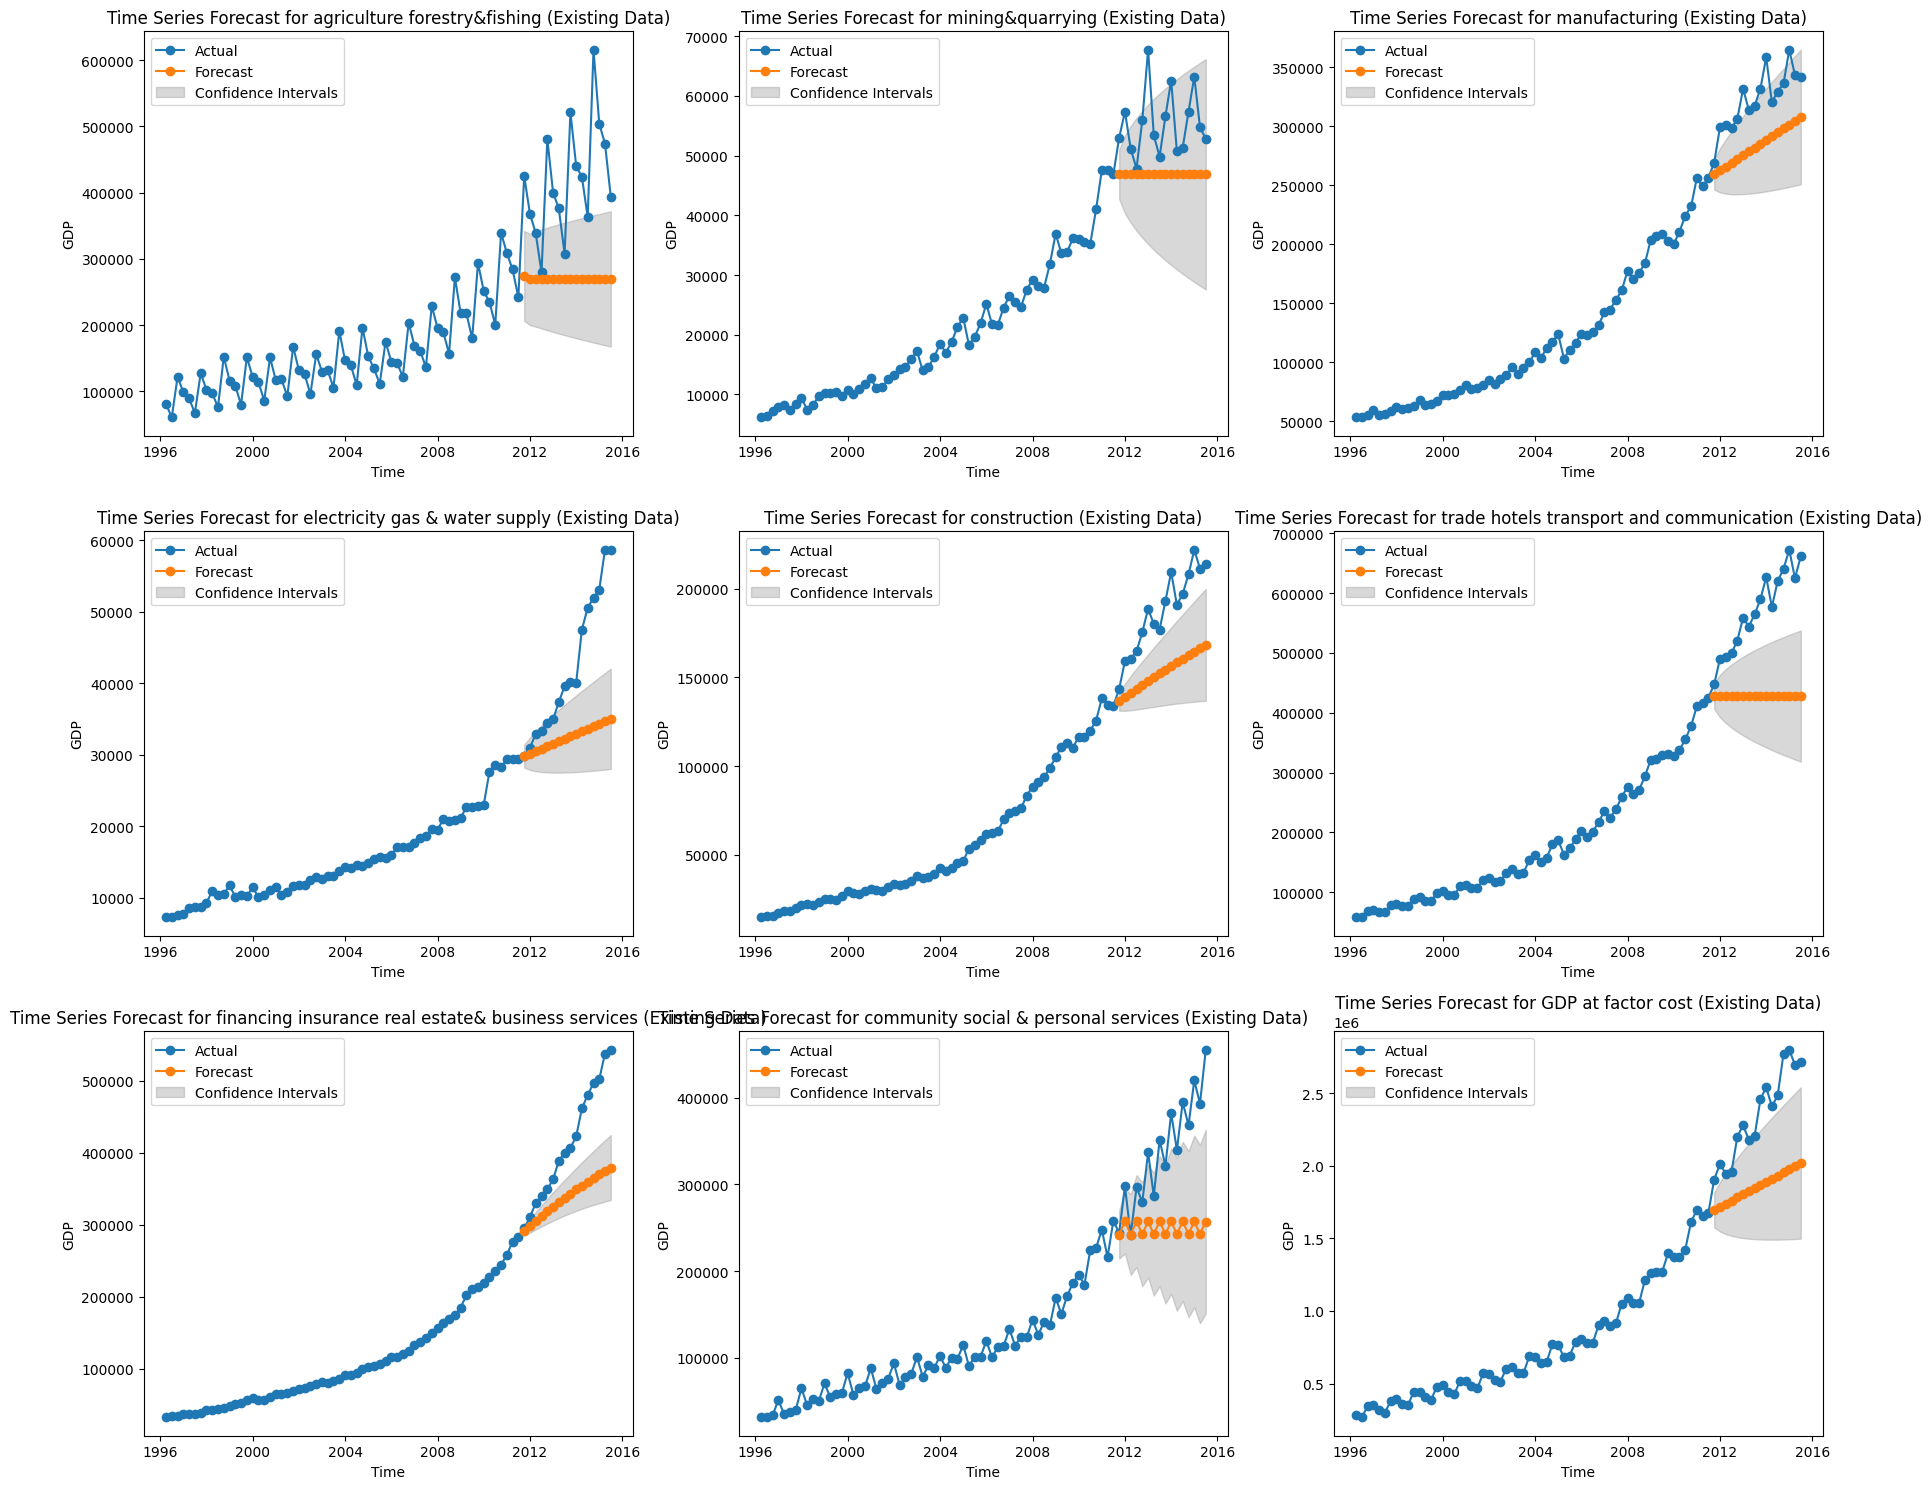

Sector: agriculture forestry&fishing
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 171033.7623044866
Mean Absolute Error (MAE) for Existing Data (Test Set): 149518.86398777005
Mean Squared Error (MSE) for Existing Data (Test Set): 29252547848.027615

Sector: mining&quarrying
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 9967.101930379496
Mean Absolute Error (MAE) for Existing Data (Test Set): 8489.841394965131
Mean Squared Error (MSE) for Existing Data (Test Set): 99343120.8905747

Sector: manufacturing
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 41481.332875186585
Mean Absolute Error (MAE) for Existing Data (Test Set): 39073.49043698363
Mean Squared Error (MSE) for Existing Data (Test Set): 1720700977.1020355

Sector: electricity gas & water supply
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 12547.167785906508
Mean Absolute Error (MAE) for Existing Data (Test Set): 9706.555067266068
Mean Squared Error (MSE) for Existing D

In [ ]:
def forecast_existing_gdp(file_path, sector):
    # Read the processed data
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    # Calculate the number of records for the training set (80% of total records)
    num_records = len(df)
    num_train_records = int(0.8 * num_records)

    # Split the data into train and test sets
    train = df[:num_train_records]  # Use 70% of data for training
    test = df[num_train_records:]   # Use the remaining 30% for testing (forecasting)

    # Train the ARIMA model
    order = (1, 1, 1)  # (p, d, q) order
    model = ARIMA(train['GDP'], order=order)
    model_fit = model.fit()

    # Forecast for the test set (existing data)
    n_periods = len(test)  # Forecast for the number of quarters in the test set
    forecast = model_fit.get_forecast(steps=n_periods)

    # Get the forecasted values and confidence intervals for the test set (existing data)
    forecast_values = forecast.predicted_mean
    ci = forecast.conf_int(alpha=0.05)  # 95% confidence intervals

    # Calculate the difference between actual GDP and predicted GDP
    difference = test['GDP'].values - forecast_values.values

    # Calculate the percentage difference
    percentage_diff = (difference / test['GDP'].values) * 100

    # Print the sector and forecasted values for the test set (existing data)
    print(f"Sector: {sector}")
    print("Forecasted Values for Existing Data (Test Set):")
    forecast_df = pd.DataFrame({
        'Time': test.index,
        'Actual GDP': test['GDP'].values,
        'Predicted GDP': forecast_values.values,
        'Lower CI': ci.iloc[:, 0].values,
        'Upper CI': ci.iloc[:, 1].values,
        'Difference': difference,
        'Percentage Difference': percentage_diff
    })
    print(forecast_df)
    print()

    # Calculate the RMSE for the test set (existing data)
    mse = mean_squared_error(test['GDP'], forecast_values)
    rmse = np.sqrt(mse)

    # Calculate the Mean Absolute Error (MAE) for the test set (existing data)
    mae = mean_absolute_error(test['GDP'], forecast_values)

    # Print the sector, RMSE, and MAE for the test set (existing data)
    print(f"Sector: {sector}")
    print(f"Root Mean Squared Error (RMSE) for Existing Data (Test Set): {rmse}")
    print(f"Mean Absolute Error (MAE) for Existing Data (Test Set): {mae}")
    print(f"Mean Squared Error (MSE) for Existing Data (Test Set): {mse}")
    print()

    # Plot the actual data, forecast for the test set (existing data), and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['GDP'], label='Actual', linestyle='-', marker='o')
    plt.plot(test.index, forecast_values, label='Forecast', linestyle='-', marker='o')
    plt.fill_between(test.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.title(f'Time Series Forecast for {sector} (Existing Data)')
    plt.legend()
    plt.show()

    return forecast_values, ci.iloc[:, 0], ci.iloc[:, 1], rmse, mae, mse, num_train_records


# Initialize lists to store forecast values, confidence intervals, RMSE, MAE, MSE, and num_train_records for each sector
all_forecast_values = []
all_ci_lower = []
all_ci_upper = []
all_rmse_values = []
all_mae_values = []
all_mse_values = []
all_num_train_records = []

# Process each CSV file in the folder and store forecast values, confidence intervals, RMSE, MAE, MSE, and num_train_records
for file_path, sector in zip(file_paths, sectors):
    forecast_values, ci_lower, ci_upper, rmse, mae, mse, num_train_records = forecast_existing_gdp(file_path, sector)
    all_forecast_values.append(forecast_values)
    all_ci_lower.append(ci_lower)
    all_ci_upper.append(ci_upper)
    all_rmse_values.append(rmse)
    all_mae_values.append(mae)
    all_mse_values.append(mse)
    all_num_train_records.append(num_train_records)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Plot the graphs for each sector in the corresponding subplot
for i, (file_path, sector) in enumerate(zip(file_paths, sectors)):
    ax = axes[i // 3, i % 3]
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    num_train_records = all_num_train_records[i]
    ax.plot(df.index, df['GDP'], label='Actual', linestyle='-', marker='o')
    ax.plot(df.index[num_train_records:], all_forecast_values[i], label='Forecast', linestyle='-', marker='o')
    ax.fill_between(df.index[num_train_records:], all_ci_lower[i], all_ci_upper[i], color='gray', alpha=0.3, label='Confidence Intervals')
    ax.set_xlabel('Time')
    ax.set_ylabel('GDP')
    ax.set_title(f'Time Series Forecast for {sector} (Existing Data)')
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print RMSE, MAE, and MSE values for all sectors
for i, sector in enumerate(sectors):
    print(f"Sector: {sector}")
    print(f"Root Mean Squared Error (RMSE) for Existing Data (Test Set): {all_rmse_values[i]}")
    print(f"Mean Absolute Error (MAE) for Existing Data (Test Set): {all_mae_values[i]}")
    print(f"Mean Squared Error (MSE) for Existing Data (Test Set): {all_mse_values[i]}")
    print()

**Proposed SARIMA model for GDP Forecast**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: agriculture forestry&fishing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP     Difference  Percentage Difference
0  2009-09-30      293878  297723.030262   -3845.030262              -1.308376
1  2009-12-30      251191  241389.749219    9801.250781               3.901912
2  2010-03-30      234756  244814.793163  -10058.793163              -4.284786
3  2010-06-30      200653  203965.074219   -3312.074219              -1.650648
4  2010-09-30      339335  324428.570288   14906.429712               4.392836
5  2010-12-30      308771  265606.733536   43164.266464              13.979378
6  2011-03-30      284063  271019.560907   13043.439093               4.591742
7  2011-06-30      242176  228430.834029   13745.165971               5.675693
8  2011-09-30      425335  350382.147139   74952.852861              17.622075
9  2011-12-30      368111  290252.540125   77858.459875              21.150810
10 2012-03-30      339020  296848.601258   421

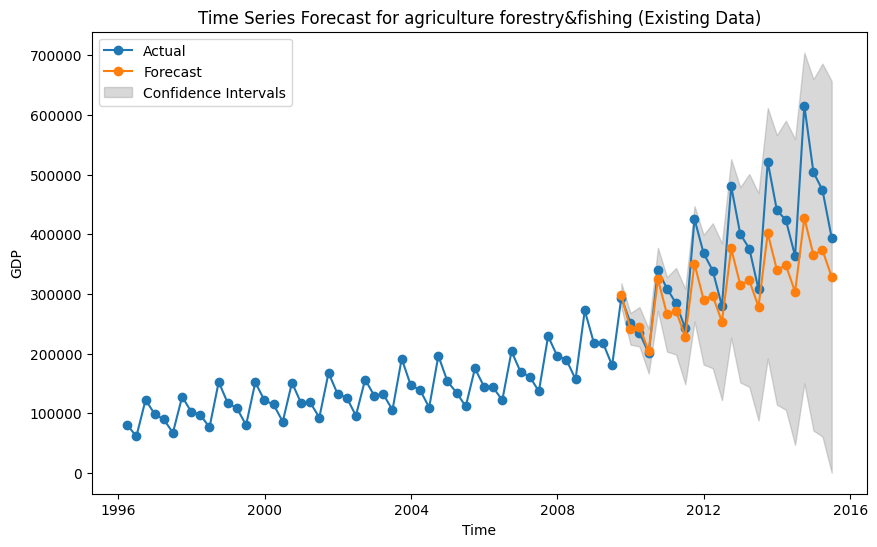

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: mining&quarrying
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30       36226   36812.569061   -586.569061              -1.619194
1  2009-12-30       36104   40024.621737  -3920.621737             -10.859245
2  2010-03-30       35498   37548.483868  -2050.483868              -5.776336
3  2010-06-30       35222   37493.560762  -2271.560762              -6.449267
4  2010-09-30       41018   40659.270859    358.729141               0.874565
5  2010-12-30       47566   44063.590753   3502.409247               7.363262
6  2011-03-30       47621   41576.781881   6044.218119              12.692338
7  2011-06-30       46858   41559.200053   5298.799947              11.308208
8  2011-09-30       53019   44721.581465   8297.418535              15.649896
9  2011-12-30       57369   48119.188661   9249.811339              16.123362
10 2012-03-30       51147   45635.547807   5511.452193              1

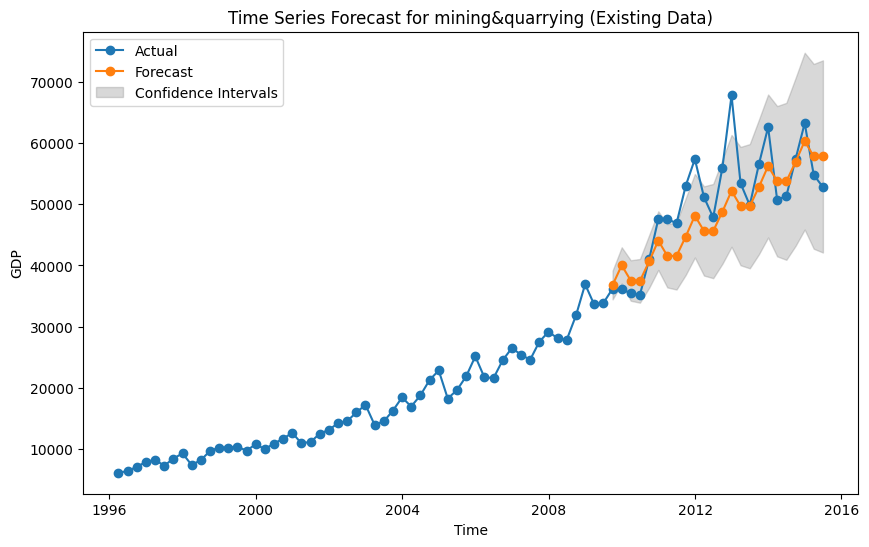

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

Sector: manufacturing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30      202739  216706.176227 -13967.176227              -6.889240
1  2009-12-30      200105  234691.439916 -34586.439916             -17.284146
2  2010-03-30      210346  236456.477829 -26110.477829             -12.413109
3  2010-06-30      223931  239409.232349 -15478.232349              -6.912054
4  2010-09-30      231935  247177.529488 -15242.529488              -6.571897
5  2010-12-30      255939  264661.333337  -8722.333337              -3.407974
6  2011-03-30      248777  265877.764740 -17100.764740              -6.873933
7  2011-06-30      255896  269078.697888 -13182.697888              -5.151584
8  2011-09-30      268972  276811.826485  -7839.826485              -2.914737
9  2011-12-30      298844  294134.814850   4709.185150               1.575800
10 2012-03-30      300511  295175.333741   5335.666259               1.7

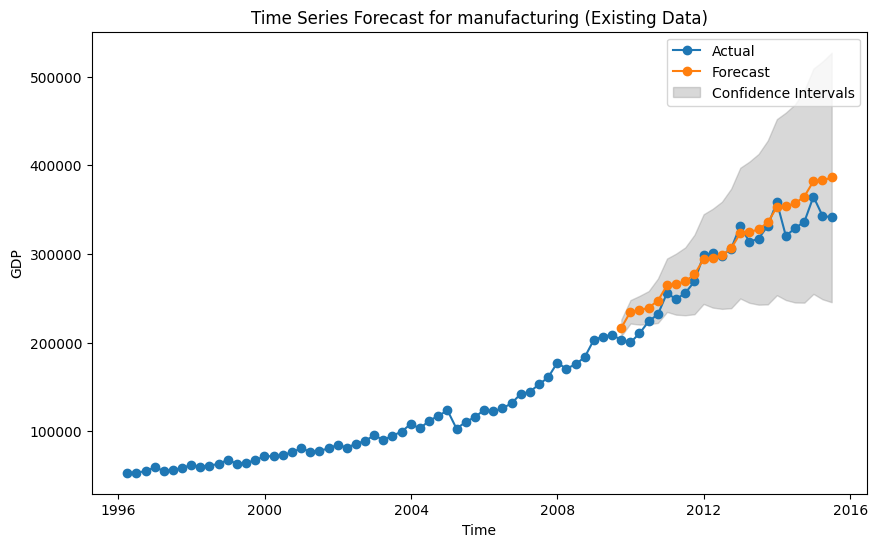

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: electricity gas & water supply
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30       22782   23107.677098   -325.677098              -1.429537
1  2009-12-30       22986   23195.492965   -209.492965              -0.911394
2  2010-03-30       27627   24792.309827   2834.690173              10.260579
3  2010-06-30       28610   24696.556957   3913.443043              13.678585
4  2010-09-30       28253   24858.574627   3394.425373              12.014389
5  2010-12-30       29394   25088.878796   4305.121204              14.646258
6  2011-03-30       29380   26563.590252   2816.409748               9.586146
7  2011-06-30       29452   26577.828124   2874.171876               9.758834
8  2011-09-30       29770   26966.358613   2803.641387               9.417673
9  2011-12-30       30959   27079.574462   3879.425538              12.530849
10 2012-03-30       32906   28654.625706   4251.374294 

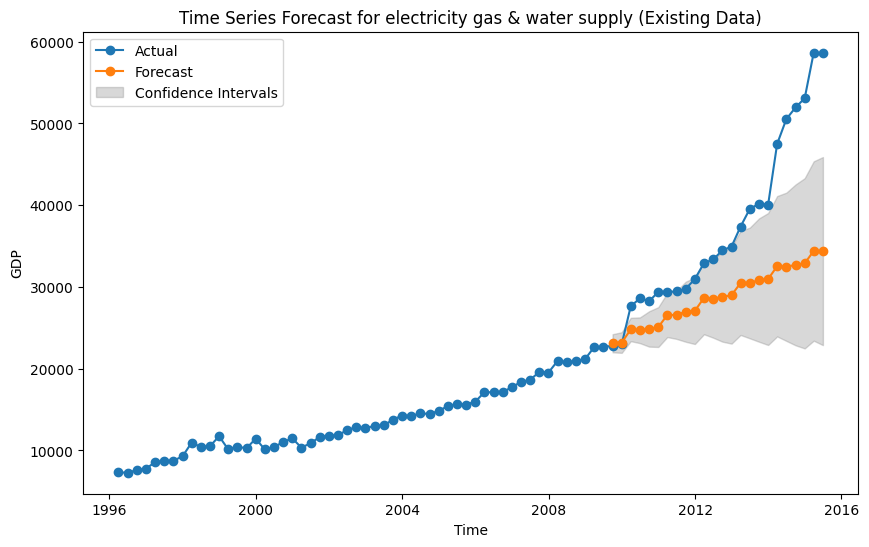

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: construction
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30      110390  118302.028627  -7912.028627              -7.167342
1  2009-12-30      116651  124035.725749  -7384.725749              -6.330615
2  2010-03-30      116384  128771.473294 -12387.473294             -10.643622
3  2010-06-30      120047  131164.481884 -11117.481884              -9.260941
4  2010-09-30      125697  136295.753826 -10598.753826              -8.431986
5  2010-12-30      138330  142016.280626  -3686.280626              -2.664845
6  2011-03-30      134616  146511.960261 -11895.960261              -8.836959
7  2011-06-30      134085  148937.656005 -14852.656005             -11.077045
8  2011-09-30      143525  154053.069721 -10528.069721              -7.335356
9  2011-12-30      159309  159778.486103   -469.486103              -0.294702
10 2012-03-30      160670  164223.661358  -3553.661358              -2.21

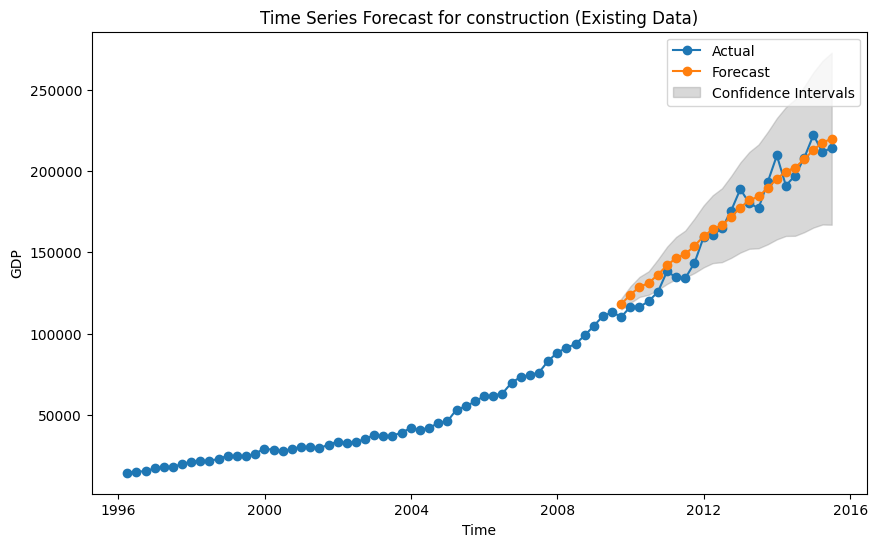

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: trade hotels transport and communication
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30      330738  352588.114114 -21850.114114              -6.606472
1  2009-12-30      327165  379738.883217 -52573.883217             -16.069532
2  2010-03-30      337672  381169.961324 -43497.961324             -12.881720
3  2010-06-30      355468  387946.484847 -32478.484847              -9.136824
4  2010-09-30      377698  410675.974340 -32977.974340              -8.731308
5  2010-12-30      410784  437744.626618 -26960.626618              -6.563212
6  2011-03-30      416869  439066.646161 -22197.646161              -5.324849
7  2011-06-30      425280  445854.896838 -20574.896838              -4.837965
8  2011-09-30      447330  468578.373267 -21248.373267              -4.750044
9  2011-12-30      490152  495626.658126  -5474.658126              -1.116931
10 2012-03-30      492924  496921.908258  -39

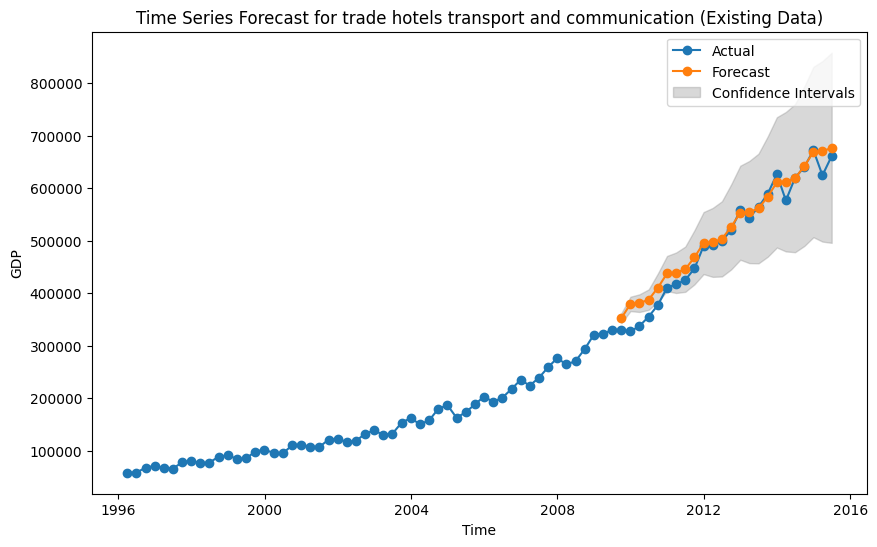

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: financing insurance real estate& business services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2009-09-30      213657  216359.206025  -2702.206025              -1.264740
1  2009-12-30      219435  227793.886766  -8358.886766              -3.809277
2  2010-03-30      227211  245510.675001 -18299.675001              -8.054044
3  2010-06-30      235354  254382.261458 -19028.261458              -8.084953
4  2010-09-30      244168  260400.167090 -16232.167090              -6.647950
5  2010-12-30      258204  272120.917160 -13916.917160              -5.389892
6  2011-03-30      276202  290534.878265 -14332.878265              -5.189274
7  2011-06-30      283515  299657.497573 -16142.497573              -5.693701
8  2011-09-30      294757  305740.887067 -10983.887067              -3.726421
9  2011-12-30      310769  317696.693085  -6927.693085              -2.229210
10 2012-03-30      329595  336683.5

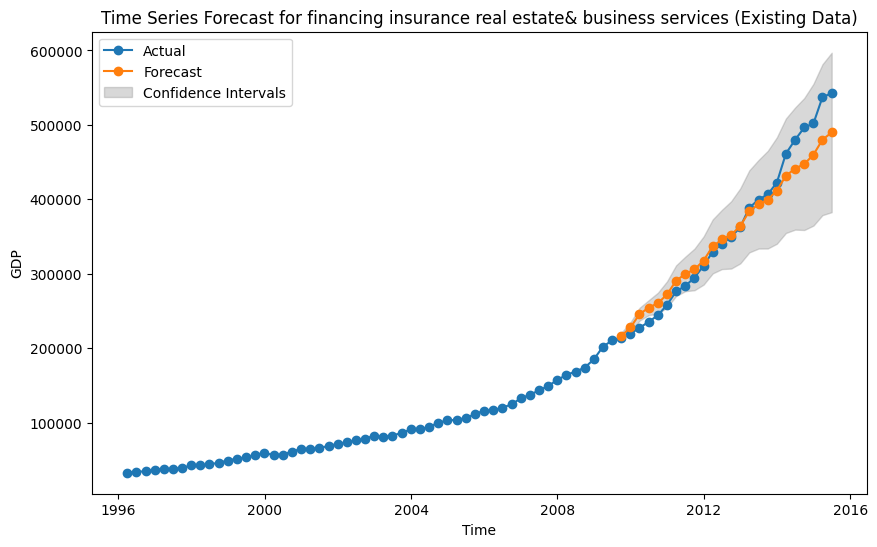

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: community social & personal services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP     Difference  Percentage Difference
0  2009-09-30      186429  165338.765052   21090.234948              11.312744
1  2009-12-30      195779  196100.355495    -321.355495              -0.164142
2  2010-03-30      184251  176505.625721    7745.374279               4.203708
3  2010-06-30      224306  197383.276926   26922.723074              12.002676
4  2010-09-30      226746  191085.253784   35660.746216              15.727178
5  2010-12-30      247730  221735.757022   25994.242978              10.492973
6  2011-03-30      216000  202097.394863   13902.605137               6.436391
7  2011-06-30      257863  222934.864874   34928.135126              13.545229
8  2011-09-30      244011  216630.620559   27380.379441              11.220961
9  2011-12-30      297977  247269.981435   50707.018565              17.017091
10 2012-03-30      241157  227629.9067

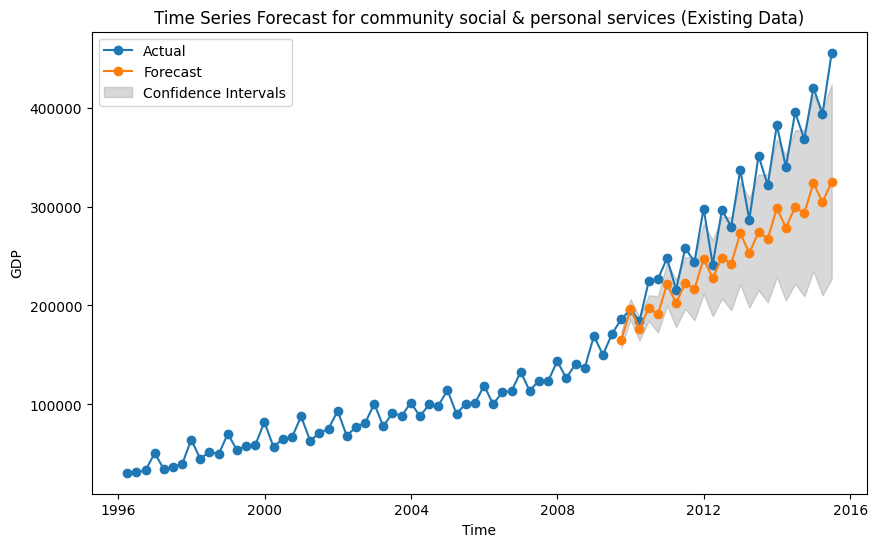

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Sector: GDP at factor cost
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP     Difference  Percentage Difference
0  2009-09-30     1396840   1.427168e+06  -30327.605410              -2.171158
1  2009-12-30     1369417   1.473762e+06 -104345.335210              -7.619690
2  2010-03-30     1373744   1.480469e+06 -106724.736370              -7.768896
3  2010-06-30     1423590   1.483667e+06  -60076.955895              -4.220102
4  2010-09-30     1614850   1.640502e+06  -25652.256372              -1.588523
5  2010-12-30     1696719   1.687069e+06    9649.733717               0.568729
6  2011-03-30     1653529   1.693686e+06  -40156.785859              -2.428550
7  2011-06-30     1675124   1.696879e+06  -21755.079648              -1.298715
8  2011-09-30     1906718   1.853710e+06   53008.047565               2.780068
9  2011-12-30     2013488   1.900275e+06  113213.491128               5.622755
10 2012-03-30     1947931   1.906883e+06   41047.913846 

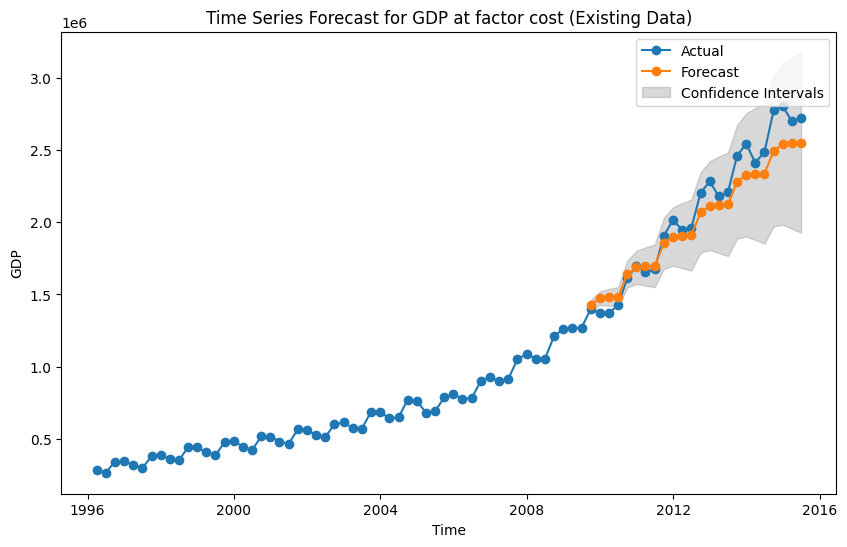

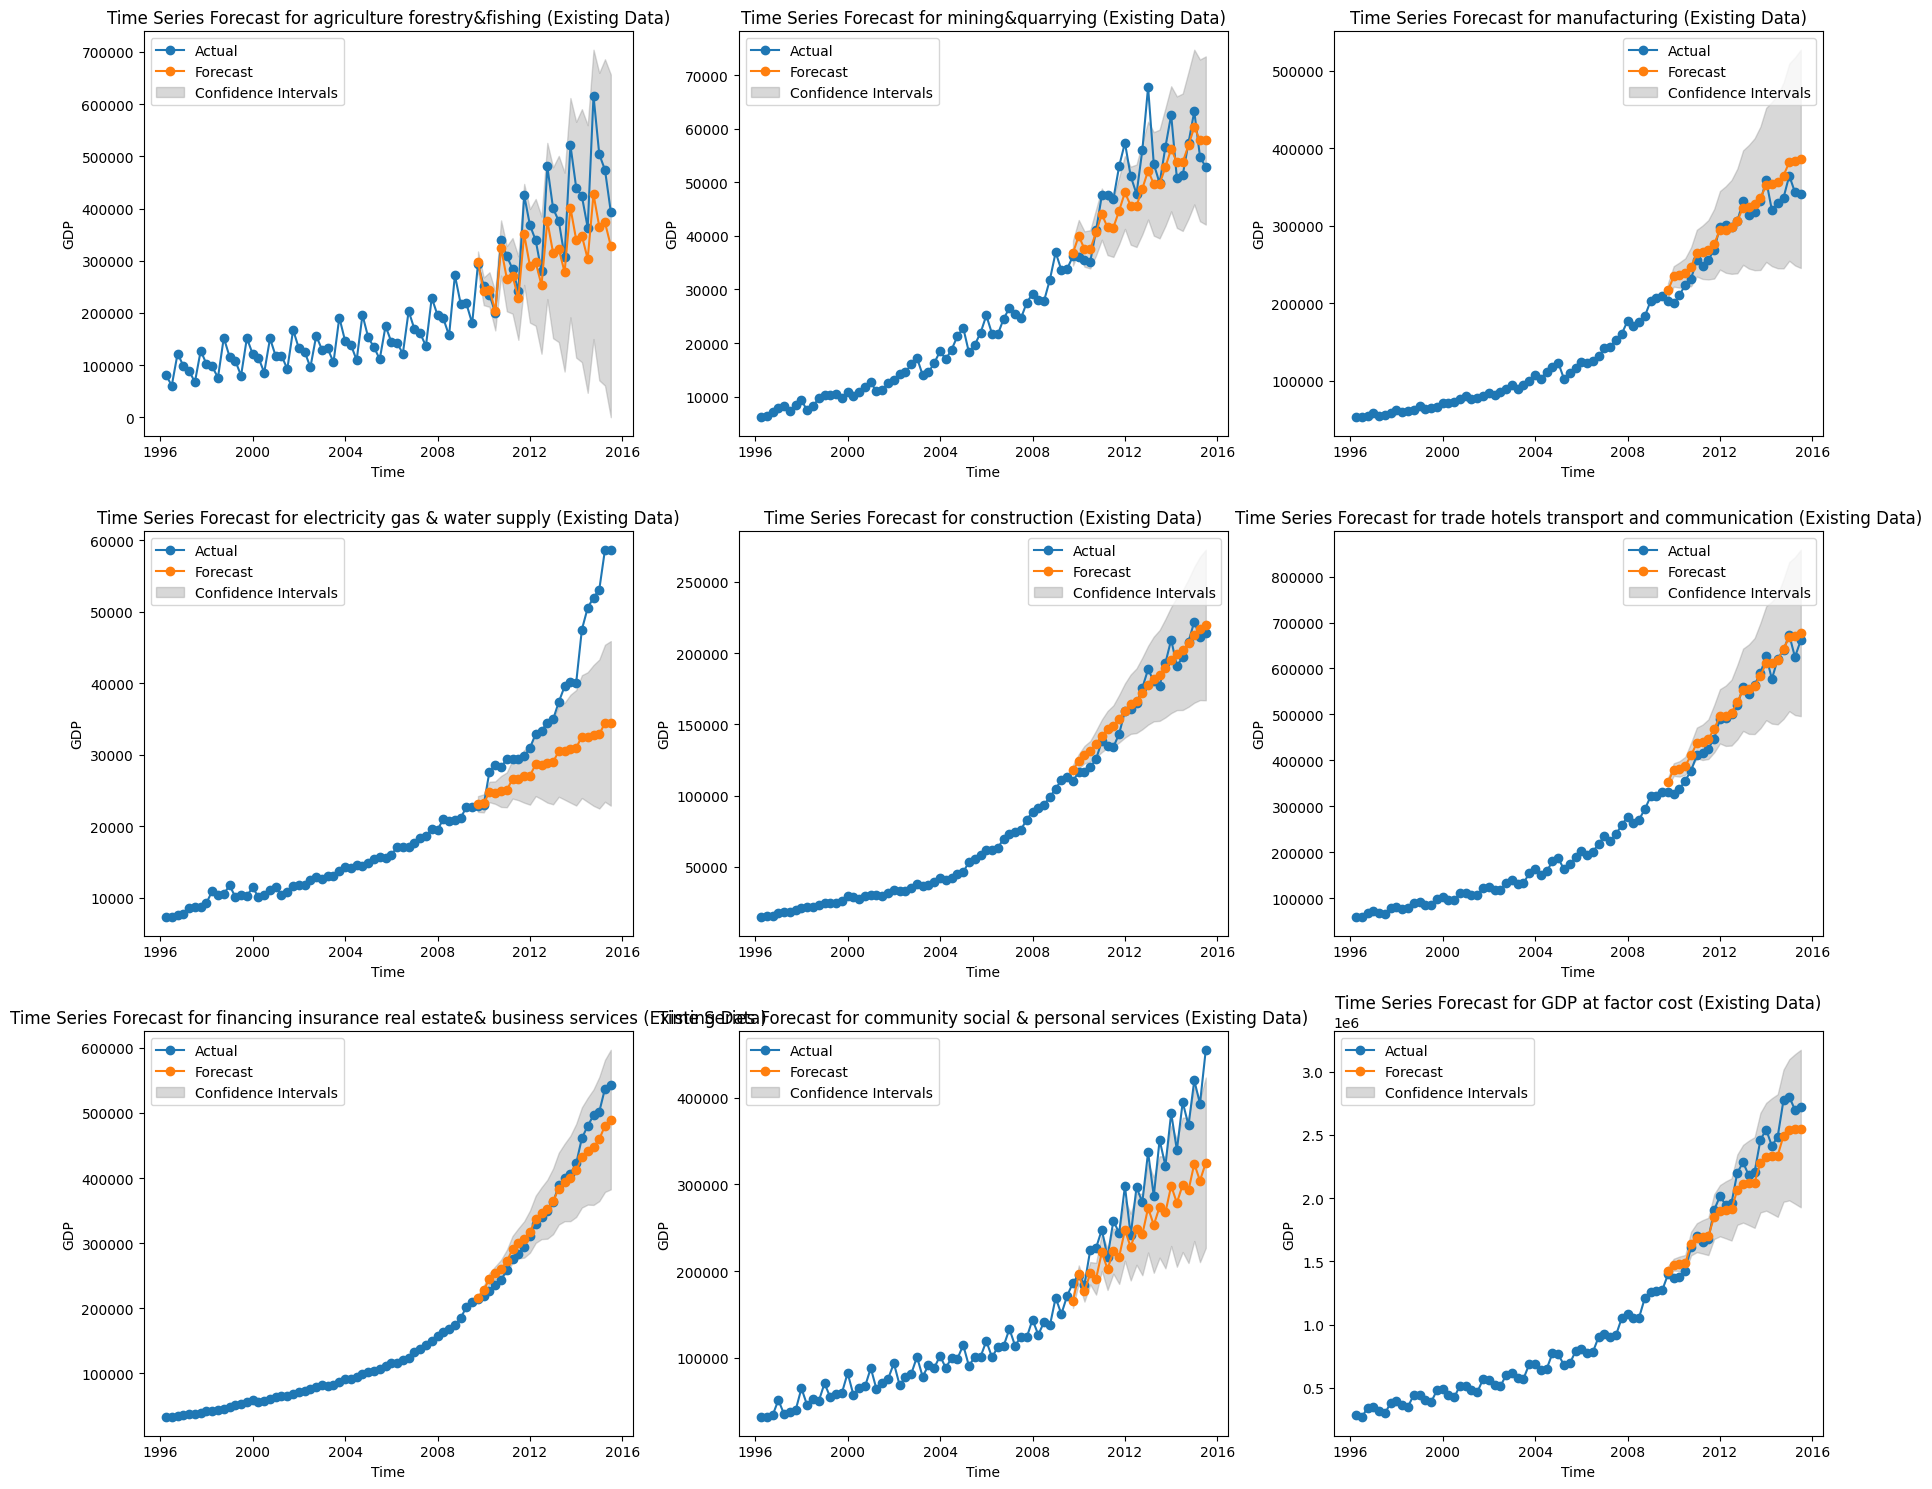

Sector: agriculture forestry&fishing
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 76767.27595494059
Mean Absolute Error (MAE) for Existing Data (Test Set): 60574.85013552558
Mean Squared Error (MSE) for Existing Data (Test Set): 5893214657.541999

Sector: mining&quarrying
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 5447.484194582102
Mean Absolute Error (MAE) for Existing Data (Test Set): 4287.72027692516
Mean Squared Error (MSE) for Existing Data (Test Set): 29675084.050221812

Sector: manufacturing
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 20587.150219144674
Mean Absolute Error (MAE) for Existing Data (Test Set): 16416.633490946133
Mean Squared Error (MSE) for Existing Data (Test Set): 423830754.14562863

Sector: electricity gas & water supply
Root Mean Squared Error (RMSE) for Existing Data (Test Set): 11185.54587815602
Mean Absolute Error (MAE) for Existing Data (Test Set): 8471.284718056086
Mean Squared Error (MSE) for Existing Da

In [ ]:
def forecast_existing_gdp(file_path, sector):
    # Read the processed data
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    # Calculate the number of records for the training set (80% of total records)
    num_records = len(df)
    num_train_records = int(0.7 * num_records)

    # Split the data into train and test sets
    train = df[:num_train_records]  # Use 70% of data for training
    test = df[num_train_records:]   # Use the remaining 30% for testing (forecasting)

    # Train the SARIMA model
    order = (1, 1, 1)  # (p, d, q) order
    seasonal_order = (1, 1, 1, 4)  # (P, D, Q, S) seasonal order
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Forecast for the test set (existing data)
    n_periods = len(test)  # Forecast for the number of quarters in the test set
    forecast = model_fit.get_forecast(steps=n_periods)

    # Get the forecasted values and confidence intervals for the test set (existing data)
    forecast_values = forecast.predicted_mean
    ci_lower = forecast.conf_int().iloc[:, 0]
    ci_upper = forecast.conf_int().iloc[:, 1]

    # Calculate the difference between actual GDP and predicted GDP
    difference = test['GDP'].values - forecast_values.values

    # Calculate the percentage difference
    percentage_diff = (difference / test['GDP'].values) * 100

    # Print the sector and forecasted values for the test set (existing data)
    print(f"Sector: {sector}")
    print("Forecasted Values for Existing Data (Test Set):")
    forecast_df = pd.DataFrame({
        'Time': test.index,
        'Actual GDP': test['GDP'].values,
        'Predicted GDP': forecast_values.values,
        'Difference': difference,
        'Percentage Difference': percentage_diff
    })
    print(forecast_df)
    print()

    # Calculate the RMSE for the test set (existing data)
    mse = mean_squared_error(test['GDP'], forecast_values)
    rmse = np.sqrt(mse)

    # Calculate the Mean Absolute Error (MAE) for the test set (existing data)
    mae = mean_absolute_error(test['GDP'], forecast_values)

    # Print the sector, RMSE, and MAE for the test set (existing data)
    print(f"Sector: {sector}")
    print(f"Root Mean Squared Error (RMSE) for Existing Data (Test Set): {rmse}")
    print(f"Mean Absolute Error (MAE) for Existing Data (Test Set): {mae}")
    print(f"Mean Squared Error (MSE) for Existing Data (Test Set): {mse}")
    print()

    # Plot the actual data, forecast for the test set (existing data), and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['GDP'], label='Actual', linestyle='-', marker='o')
    plt.plot(test.index, forecast_values, label='Forecast', linestyle='-', marker='o')
    plt.fill_between(test.index, ci_lower, ci_upper, color='gray', alpha=0.3, label='Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.title(f'Time Series Forecast for {sector} (Existing Data)')
    plt.legend()
    plt.show()

    return forecast_values, ci_lower, ci_upper, rmse, mae, mse, num_train_records


# Initialize lists to store forecast values, confidence intervals, RMSE, MAE, MSE, and num_train_records for each sector
all_forecast_values = []
all_ci_lower = []
all_ci_upper = []
all_rmse_values = []
all_mae_values = []
all_mse_values = []
all_num_train_records = []

# Process each CSV file in the folder and store forecast values, confidence intervals, RMSE, MAE, MSE, and num_train_records
for file_path, sector in zip(file_paths, sectors):
    forecast_values, ci_lower, ci_upper, rmse, mae, mse, num_train_records = forecast_existing_gdp(file_path, sector)
    all_forecast_values.append(forecast_values)
    all_ci_lower.append(ci_lower)
    all_ci_upper.append(ci_upper)
    all_rmse_values.append(rmse)
    all_mae_values.append(mae)
    all_mse_values.append(mse)
    all_num_train_records.append(num_train_records)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Plot the graphs for each sector in the corresponding subplot
for i, (file_path, sector) in enumerate(zip(file_paths, sectors)):
    ax = axes[i // 3, i % 3]
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    num_train_records = all_num_train_records[i]
    ax.plot(df.index, df['GDP'], label='Actual', linestyle='-', marker='o')
    ax.plot(df.index[num_train_records:], all_forecast_values[i], label='Forecast', linestyle='-', marker='o')
    ax.fill_between(df.index[num_train_records:], all_ci_lower[i], all_ci_upper[i], color='gray', alpha=0.3, label='Confidence Intervals')
    ax.set_xlabel('Time')
    ax.set_ylabel('GDP')
    ax.set_title(f'Time Series Forecast for {sector} (Existing Data)')
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print RMSE, MAE, and MSE values for all sectors
for i, sector in enumerate(sectors):
    print(f"Sector: {sector}")
    print(f"Root Mean Squared Error (RMSE) for Existing Data (Test Set): {all_rmse_values[i]}")
    print(f"Mean Absolute Error (MAE) for Existing Data (Test Set): {all_mae_values[i]}")
    print(f"Mean Squared Error (MSE) for Existing Data (Test Set): {all_mse_values[i]}")
    print()


**Proposed LSTM Model**

Epoch 1/100
49/49 - 4s - loss: 0.0602 - 4s/epoch - 83ms/step
Epoch 2/100
49/49 - 0s - loss: 0.0248 - 256ms/epoch - 5ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0271 - 309ms/epoch - 6ms/step
Epoch 4/100
49/49 - 0s - loss: 0.0243 - 333ms/epoch - 7ms/step
Epoch 5/100
49/49 - 0s - loss: 0.0219 - 312ms/epoch - 6ms/step
Epoch 6/100
49/49 - 0s - loss: 0.0222 - 273ms/epoch - 6ms/step
Epoch 7/100
49/49 - 0s - loss: 0.0204 - 307ms/epoch - 6ms/step
Epoch 8/100
49/49 - 0s - loss: 0.0212 - 294ms/epoch - 6ms/step
Epoch 9/100
49/49 - 0s - loss: 0.0212 - 333ms/epoch - 7ms/step
Epoch 10/100
49/49 - 0s - loss: 0.0229 - 361ms/epoch - 7ms/step
Epoch 11/100
49/49 - 0s - loss: 0.0218 - 393ms/epoch - 8ms/step
Epoch 12/100
49/49 - 0s - loss: 0.0207 - 435ms/epoch - 9ms/step
Epoch 13/100
49/49 - 0s - loss: 0.0205 - 430ms/epoch - 9ms/step
Epoch 14/100
49/49 - 0s - loss: 0.0198 - 390ms/epoch - 8ms/step
Epoch 15/100
49/49 - 0s - loss: 0.0184 - 381ms/epoch - 8ms/step
Epoch 16/100
49/49 - 0s - loss: 0.0176 - 460ms/epoc

1/1 [==============================] - 0s 436ms/step
Epoch 1/100
49/49 - 2s - loss: 0.0529 - 2s/epoch - 41ms/step
Epoch 2/100
49/49 - 0s - loss: 0.0080 - 148ms/epoch - 3ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0017 - 149ms/epoch - 3ms/step
Epoch 4/100
49/49 - 0s - loss: 9.4786e-04 - 170ms/epoch - 3ms/step
Epoch 5/100
49/49 - 0s - loss: 9.8372e-04 - 153ms/epoch - 3ms/step
Epoch 6/100
49/49 - 0s - loss: 0.0011 - 182ms/epoch - 4ms/step
Epoch 7/100
49/49 - 0s - loss: 9.6669e-04 - 157ms/epoch - 3ms/step
Epoch 8/100
49/49 - 0s - loss: 0.0011 - 155ms/epoch - 3ms/step
Epoch 9/100
49/49 - 0s - loss: 0.0010 - 154ms/epoch - 3ms/step
Epoch 10/100
49/49 - 0s - loss: 9.7395e-04 - 162ms/epoch - 3ms/step
Epoch 11/100
49/49 - 0s - loss: 9.6462e-04 - 159ms/epoch - 3ms/step
Epoch 12/100
49/49 - 0s - loss: 0.0012 - 155ms/epoch - 3ms/step
Epoch 13/100
49/49 - 0s - loss: 0.0010 - 162ms/epoch - 3ms/step
Epoch 14/100
49/49 - 0s - loss: 0.0014 - 172ms/epoch - 4ms/step
Epoch 15/100
49/49 - 0s - loss: 9.3562e-04

1/1 [==============================] - 0s 430ms/step
Epoch 1/100
49/49 - 2s - loss: 0.0563 - 2s/epoch - 41ms/step
Epoch 2/100
49/49 - 0s - loss: 0.0093 - 172ms/epoch - 4ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0019 - 173ms/epoch - 4ms/step
Epoch 4/100
49/49 - 0s - loss: 2.6698e-04 - 178ms/epoch - 4ms/step
Epoch 5/100
49/49 - 0s - loss: 2.0499e-04 - 159ms/epoch - 3ms/step
Epoch 6/100
49/49 - 0s - loss: 2.6053e-04 - 145ms/epoch - 3ms/step
Epoch 7/100
49/49 - 0s - loss: 2.0875e-04 - 148ms/epoch - 3ms/step
Epoch 8/100
49/49 - 0s - loss: 1.7499e-04 - 185ms/epoch - 4ms/step
Epoch 9/100
49/49 - 0s - loss: 2.0940e-04 - 164ms/epoch - 3ms/step
Epoch 10/100
49/49 - 0s - loss: 2.0532e-04 - 166ms/epoch - 3ms/step
Epoch 11/100
49/49 - 0s - loss: 1.8912e-04 - 159ms/epoch - 3ms/step
Epoch 12/100
49/49 - 0s - loss: 2.0549e-04 - 171ms/epoch - 3ms/step
Epoch 13/100
49/49 - 0s - loss: 2.6532e-04 - 181ms/epoch - 4ms/step
Epoch 14/100
49/49 - 0s - loss: 2.5463e-04 - 168ms/epoch - 3ms/step
Epoch 15/100
49/49

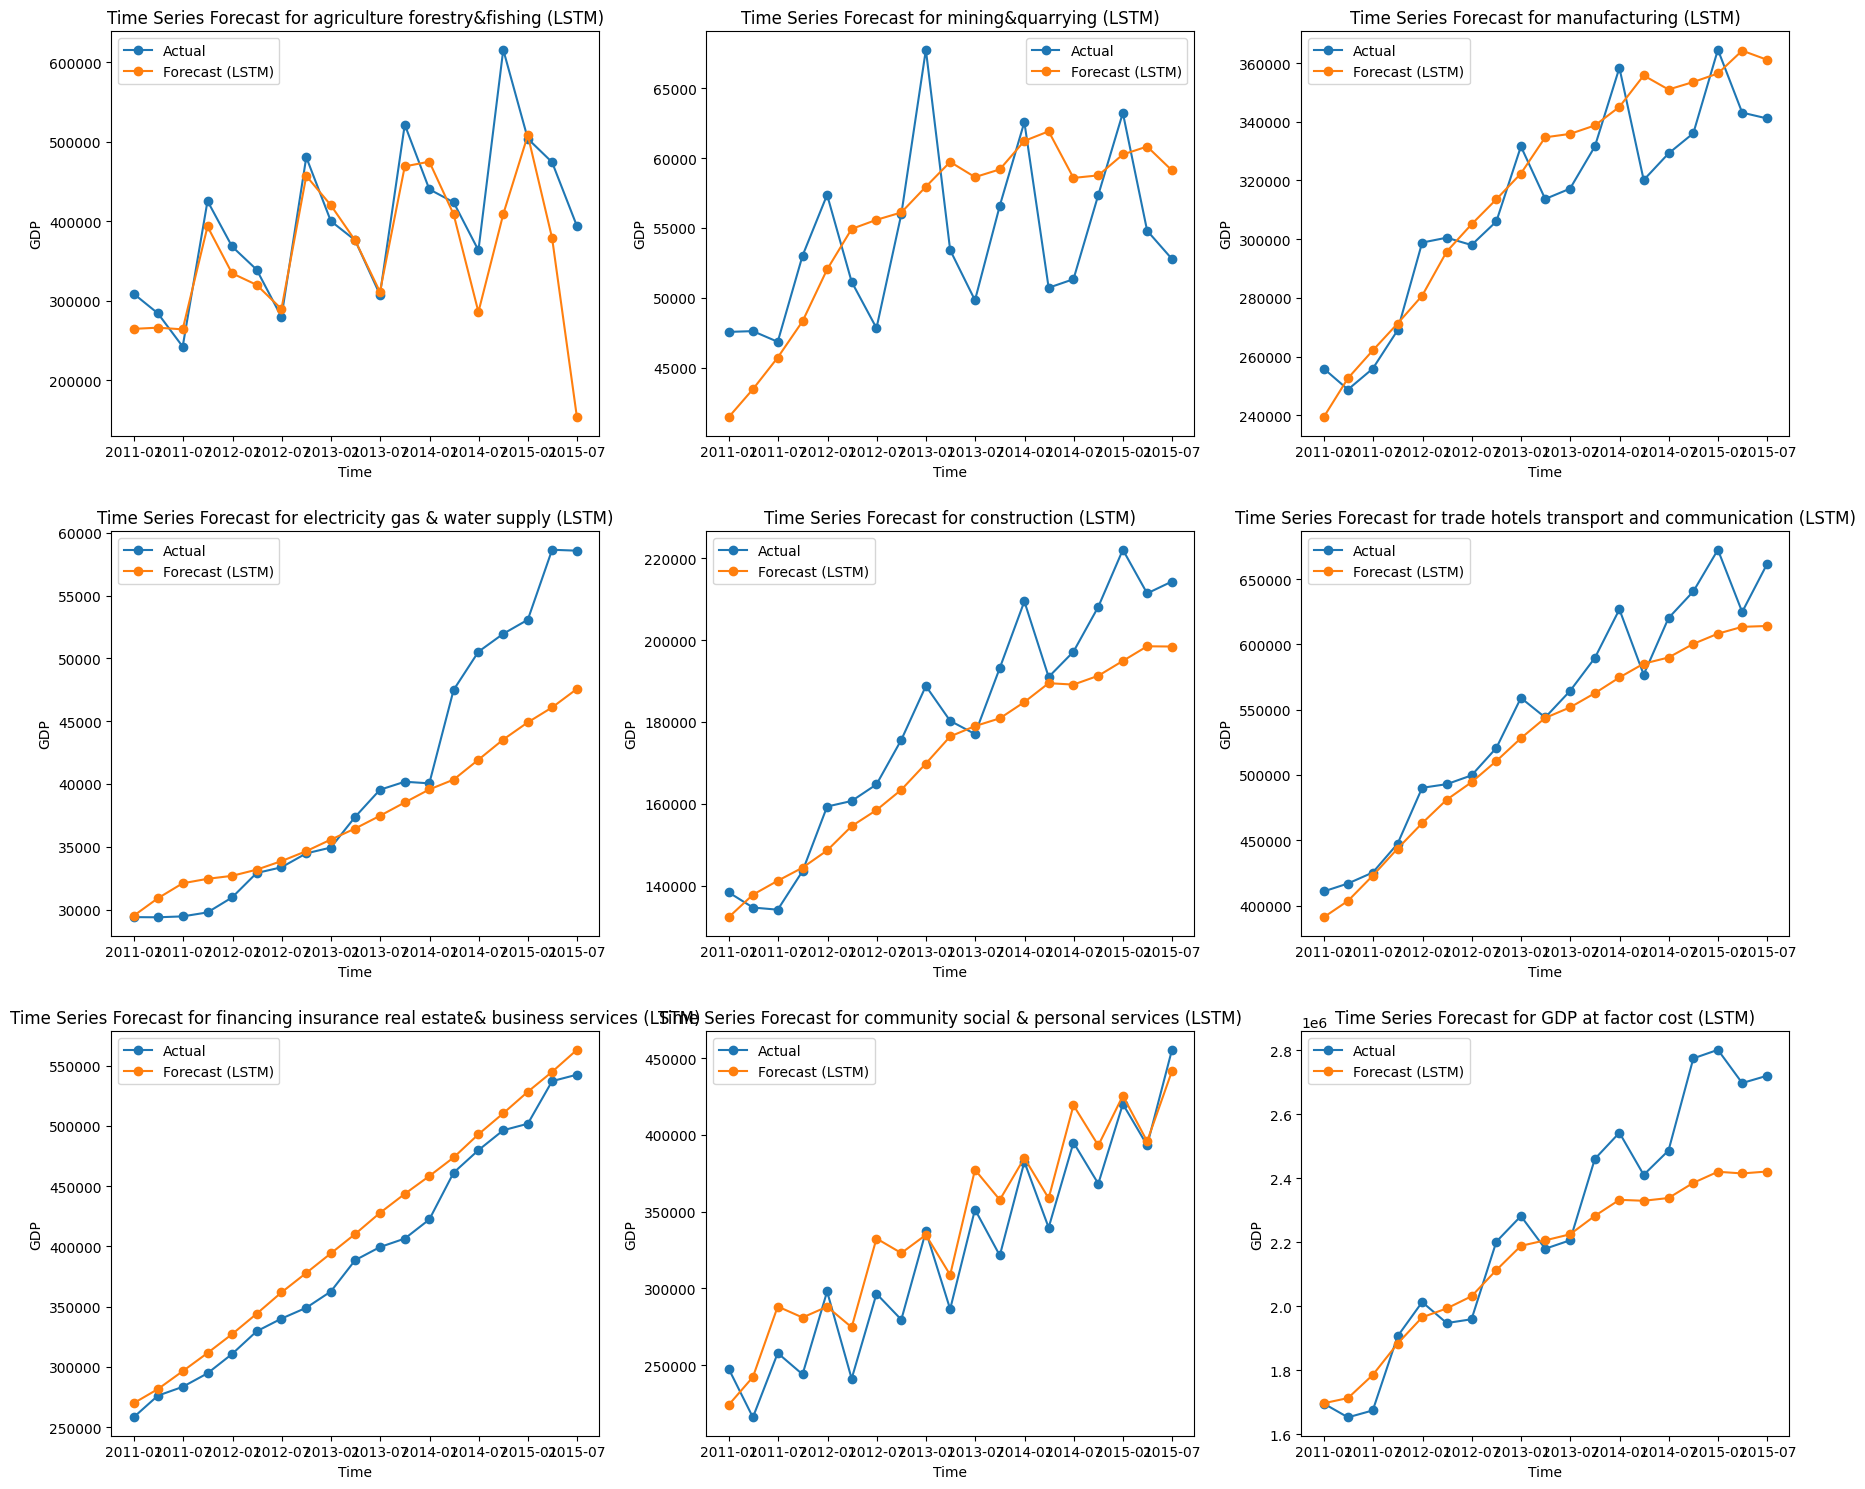

Sector: agriculture forestry&fishing
LSTM - Root Mean Squared Error (RMSE): 81521.53495269916
LSTM - Mean Squared Error (MSE): 6645760661.044151
LSTM - Mean Absolute Error (MAE): 50169.24177631579

Sector: mining&quarrying
LSTM - Root Mean Squared Error (RMSE): 5925.730635358077
LSTM - Mean Squared Error (MSE): 35114283.56282124
LSTM - Mean Absolute Error (MAE): 5108.816200657895

Sector: manufacturing
LSTM - Root Mean Squared Error (RMSE): 15983.600248475816
LSTM - Mean Squared Error (MSE): 255475476.90307617
LSTM - Mean Absolute Error (MAE): 13675.829769736842

Sector: electricity gas & water supply
LSTM - Root Mean Squared Error (RMSE): 5476.110159078121
LSTM - Mean Squared Error (MSE): 29987782.474358607
LSTM - Mean Absolute Error (MAE): 3750.421566611842

Sector: construction
LSTM - Root Mean Squared Error (RMSE): 12744.593886709697
LSTM - Mean Squared Error (MSE): 162424673.3371582
LSTM - Mean Absolute Error (MAE): 10349.518914473685

Sector: trade hotels transport and communicat

In [ ]:
# Initialize lists to store RMSE, MSE, and MAE for each sector
all_lstm_rmse_values = []
all_lstm_mse_values = []
all_lstm_mae_values = []

# Initialize a counter for subplot index
subplot_index = 0

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Process each CSV file in the folder and store RMSE, MSE, and MAE
for file_path, sector in zip(file_paths, sectors):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    num_records = len(df)
    num_train_records = int(0.7 * num_records)
    train = df[:num_train_records]
    test = df[num_train_records:]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Prepare the input features and target for LSTM model
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 5  # Sequence length for LSTM
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Create and train the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

    # Make predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

    # Calculate RMSE, MSE, and MAE
    lstm_rmse = np.sqrt(mean_squared_error(test['GDP'][seq_length:], y_pred))
    lstm_mse = mean_squared_error(test['GDP'][seq_length:], y_pred)
    lstm_mae = mean_absolute_error(test['GDP'][seq_length:], y_pred)

    all_lstm_rmse_values.append(lstm_rmse)
    all_lstm_mse_values.append(lstm_mse)
    all_lstm_mae_values.append(lstm_mae)

    # Plot the predictions in the corresponding subplot
    ax = axes[subplot_index // 3, subplot_index % 3]
    ax.plot(test.index[seq_length:], test['GDP'][seq_length:], label='Actual', linestyle='-', marker='o')
    ax.plot(test.index[seq_length:], y_pred, label='Forecast (LSTM)', linestyle='-', marker='o')
    ax.set_xlabel('Time')
    ax.set_ylabel('GDP')
    ax.set_title(f'Time Series Forecast for {sector} (LSTM)')
    ax.legend()

    # Increment the subplot index
    subplot_index += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print RMSE, MSE, and MAE values for all sectors
for i, sector in enumerate(sectors):
    print(f"Sector: {sector}")
    print(f"LSTM - Root Mean Squared Error (RMSE): {all_lstm_rmse_values[i]}")
    print(f"LSTM - Mean Squared Error (MSE): {all_lstm_mse_values[i]}")
    print(f"LSTM - Mean Absolute Error (MAE): {all_lstm_mae_values[i]}")
    print()

**Proposed RNN Model**

1/1 [==============================] - 1s 818ms/step
Sector: agriculture forestry&fishing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30      339335   266409.75000   72925.25000              21.490636
1  2010-12-30      308771   252435.84375   56335.15625              18.244964
2  2011-03-30      284063   265696.00000   18367.00000               6.465819
3  2011-06-30      242176   288745.75000  -46569.75000             -19.229713
4  2011-09-30      425335   322573.96875  102761.03125              24.160022
5  2011-12-30      368111   312431.09375   55679.90625              15.125847
6  2012-03-30      339020   327986.00000   11034.00000               3.254675
7  2012-06-30      279526   357086.28125  -77560.28125             -27.747072
8  2012-09-30      480461   398745.50000   81715.50000              17.007728
9  2012-12-30      400091   371873.28125   28217.71875               7.052825
10 2

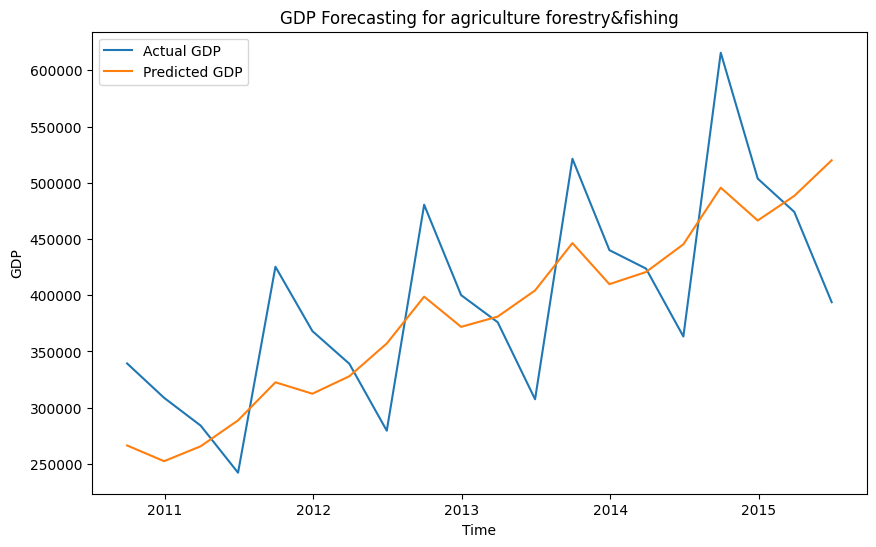

1/1 [==============================] - 1s 654ms/step
Sector: mining&quarrying
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30       41018   41515.445312   -497.445312              -1.212749
1  2010-12-30       47566   42186.179688   5379.820312              11.310222
2  2011-03-30       47621   44829.324219   2791.675781               5.862279
3  2011-06-30       46858   49212.675781  -2354.675781              -5.025131
4  2011-09-30       53019   54633.519531  -1614.519531              -3.045172
5  2011-12-30       57369   58714.425781  -1345.425781              -2.345214
6  2012-03-30       51147   61176.750000 -10029.750000             -19.609655
7  2012-06-30       47836   63787.218750 -15951.218750             -33.345637
8  2012-09-30       55985   66168.617188 -10183.617188             -18.189903
9  2012-12-30       67748   65979.445312   1768.554688               2.610490
10 2013-03-30   

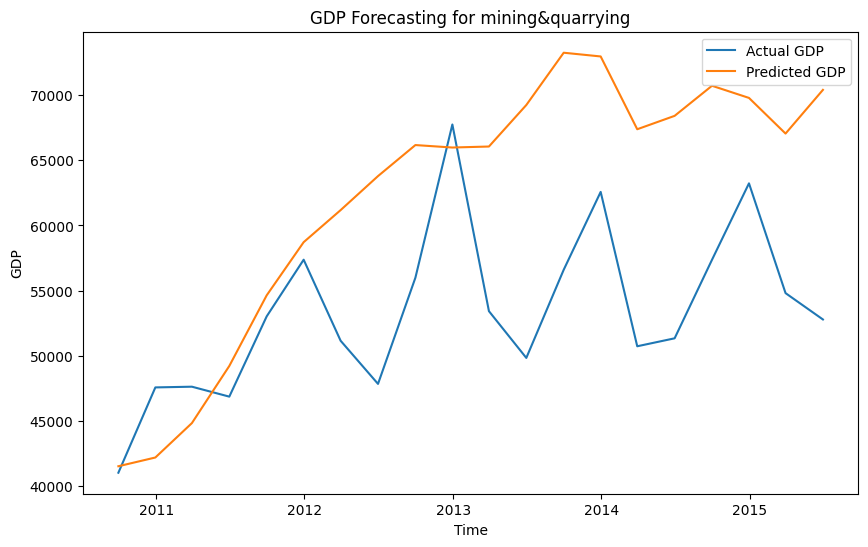

1/1 [==============================] - 0s 449ms/step
Sector: manufacturing
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP     Difference  Percentage Difference
0  2010-09-30      231935  246521.531250  -14586.531250              -6.289060
1  2010-12-30      255939  255908.390625      30.609375               0.011960
2  2011-03-30      248777  274745.281250  -25968.281250             -10.438377
3  2011-06-30      255896  292837.718750  -36941.718750             -14.436224
4  2011-09-30      268972  307457.656250  -38485.656250             -14.308425
5  2011-12-30      298844  322257.343750  -23413.343750              -7.834637
6  2012-03-30      300511  331568.718750  -31057.718750             -10.334969
7  2012-06-30      298014  352457.000000  -54443.000000             -18.268605
8  2012-09-30      306048  374373.437500  -68325.437500             -22.325072
9  2012-12-30      331609  392743.656250  -61134.656250             -18.435765
10 2013-

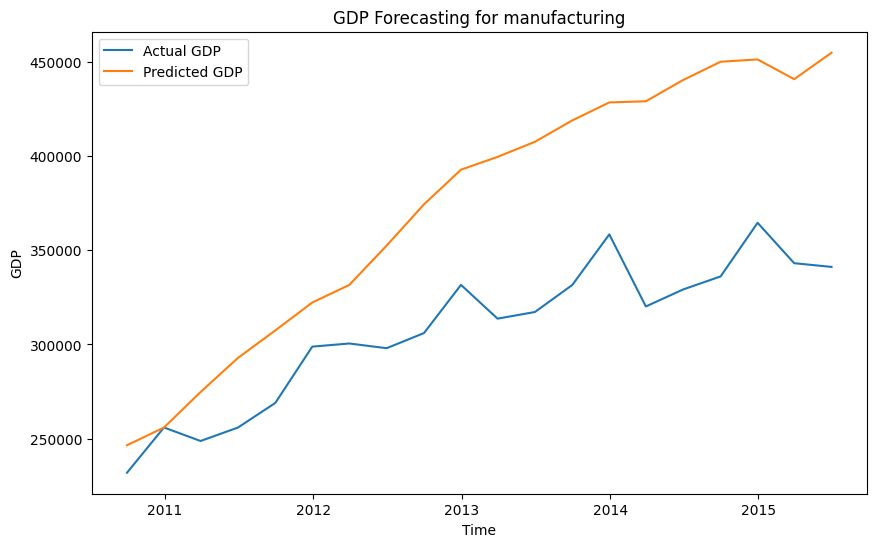

1/1 [==============================] - 0s 466ms/step
Sector: electricity gas & water supply
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP   Difference  Percentage Difference
0  2010-09-30       28253   26894.062500  1358.937500               4.809887
1  2010-12-30       29394   28908.335938   485.664062               1.652256
2  2011-03-30       29380   31287.365234 -1907.365234              -6.492053
3  2011-06-30       29452   31897.296875 -2445.296875              -8.302651
4  2011-09-30       29770   32184.330078 -2414.330078              -8.109943
5  2011-12-30       30959   32734.289062 -1775.289062              -5.734323
6  2012-03-30       32906   33027.855469  -121.855469              -0.370314
7  2012-06-30       33361   33813.042969  -452.042969              -1.355004
8  2012-09-30       34470   35023.835938  -553.835938              -1.606719
9  2012-12-30       34933   36558.812500 -1625.812500              -4.654088
10 2013-03-30

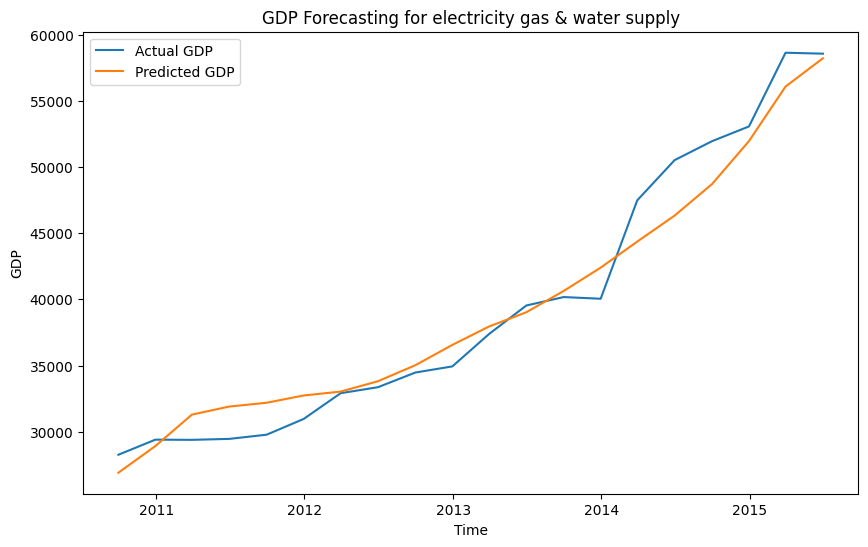

1/1 [==============================] - 0s 479ms/step
Sector: construction
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30      125697  140045.140625 -14348.140625             -11.414863
1  2010-12-30      138330  145404.875000  -7074.875000              -5.114491
2  2011-03-30      134616  151361.968750 -16745.968750             -12.439806
3  2011-06-30      134085  159490.531250 -25405.531250             -18.947333
4  2011-09-30      143525  166802.531250 -23277.531250             -16.218451
5  2011-12-30      159309  173326.640625 -14017.640625              -8.799026
6  2012-03-30      160670  177555.953125 -16885.953125             -10.509711
7  2012-06-30      164722  187563.656250 -22841.656250             -13.866791
8  2012-09-30      175625  201319.468750 -25694.468750             -14.630302
9  2012-12-30      188780  214015.640625 -25235.640625             -13.367751
10 2013-03-30      1

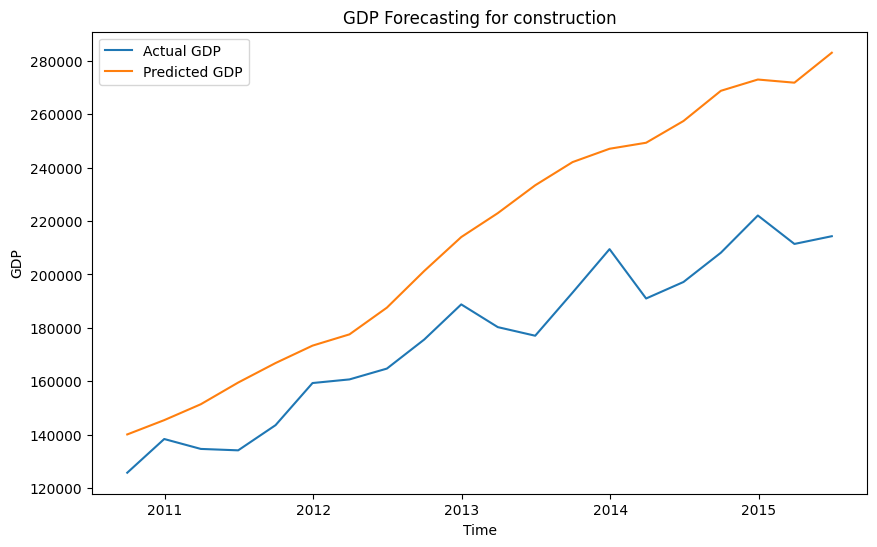

1/1 [==============================] - 1s 508ms/step
Sector: trade hotels transport and communication
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30      377698   397015.50000  -19317.50000              -5.114536
1  2010-12-30      410784   409077.28125    1706.71875               0.415478
2  2011-03-30      416869   434851.46875  -17982.46875              -4.313698
3  2011-06-30      425280   466281.03125  -41001.03125              -9.640950
4  2011-09-30      447330   496937.50000  -49607.50000             -11.089688
5  2011-12-30      490152   524022.59375  -33870.59375              -6.910222
6  2012-03-30      492924   544811.25000  -51887.25000             -10.526420
7  2012-06-30      499664   574447.62500  -74783.62500             -14.966783
8  2012-09-30      520682   609000.31250  -88318.31250             -16.962044
9  2012-12-30      559002   639655.68750  -80653.68750             -14

1/1 [==============================] - 1s 863ms/step
Sector: financing insurance real estate& business services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30      244168   275826.75000  -31658.75000             -12.965970
1  2010-12-30      258204   287139.21875  -28935.21875             -11.206340
2  2011-03-30      276202   300917.56250  -24715.56250              -8.948365
3  2011-06-30      283515   317801.00000  -34286.00000             -12.093187
4  2011-09-30      294757   337506.71875  -42749.71875             -14.503377
5  2011-12-30      310769   359225.00000  -48456.00000             -15.592289
6  2012-03-30      329595   380101.65625  -50506.65625             -15.323854
7  2012-06-30      340147   398646.00000  -58499.00000             -17.198153
8  2012-09-30      349152   421611.28125  -72459.28125             -20.752933
9  2012-12-30      362630   445654.87500  -83024.87500      

1/1 [==============================] - 0s 489ms/step
Sector: community social & personal services
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP    Difference  Percentage Difference
0  2010-09-30      226746  207284.750000  19461.250000               8.582842
1  2010-12-30      247730  218039.062500  29690.937500              11.985201
2  2011-03-30      216000  231303.968750 -15303.968750              -7.085171
3  2011-06-30      257863  250592.328125   7270.671875               2.819587
4  2011-09-30      244011  256091.750000 -12080.750000              -4.950904
5  2011-12-30      297977  262783.187500  35193.812500              11.810916
6  2012-03-30      241157  267831.968750 -26674.968750             -11.061246
7  2012-06-30      296508  288063.781250   8444.218750               2.847889
8  2012-09-30      279642  293691.375000 -14049.375000              -5.024058
9  2012-12-30      337125  308402.500000  28722.500000               8.519

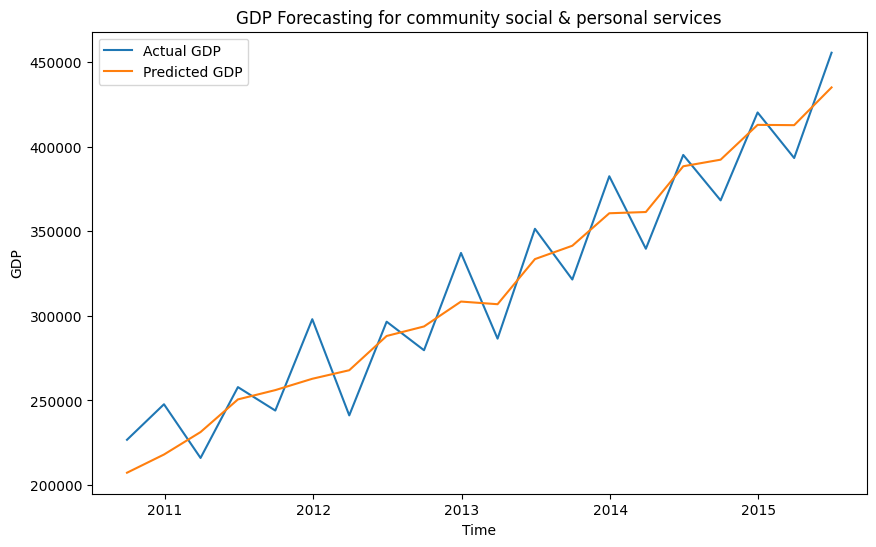

1/1 [==============================] - 1s 684ms/step
Sector: GDP at factor cost
Forecasted Values for Existing Data (Test Set):
         Time  Actual GDP  Predicted GDP  Difference  Percentage Difference
0  2010-09-30     1614850    1618620.125   -3770.125              -0.233466
1  2010-12-30     1696719    1657732.875   38986.125               2.297736
2  2011-03-30     1653529    1755685.625 -102156.625              -6.178097
3  2011-06-30     1675124    1878302.125 -203178.125             -12.129139
4  2011-09-30     1906718    1996409.000  -89691.000              -4.703947
5  2011-12-30     2013488    2066455.375  -52967.375              -2.630628
6  2012-03-30     1947931    2146568.000 -198637.000             -10.197332
7  2012-06-30     1959778    2278066.000 -318288.000             -16.241023
8  2012-09-30     2202066    2419961.750 -217895.750              -9.895060
9  2012-12-30     2281917    2490217.250 -208300.250              -9.128301
10 2013-03-30     2179887    2550345

In [ ]:
# Function to create sequences for RNN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

# Hyperparameters
seq_length = 4
n_epochs = 50
batch_size = 32

for file_path, sector in zip(file_paths, sectors):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    num_records = len(df)
    num_train_records = int(0.7 * num_records)
    train = df[:num_train_records]
    test = df[num_train_records:]

    # Normalize the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[['GDP']])

    # Create sequences for training
    train_sequences = create_sequences(train_scaled, seq_length)
    X_train = np.array([seq for seq, _ in train_sequences])
    y_train = np.array([target for _, target in train_sequences])

    # Build and train the RNN model
    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

    # Prepare test data
    test_scaled = scaler.transform(test[['GDP']])
    test_sequences = create_sequences(test_scaled, seq_length)
    X_test = np.array([seq for seq, _ in test_sequences])
    y_test = np.array([target for _, target in test_sequences])

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform to get actual GDP values
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test)

    # Calculate RMSE, MSE, and MAE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)

    # Print results
    print(f"Sector: {sector}")
    print("Forecasted Values for Existing Data (Test Set):")
    rnn_forecast_df = pd.DataFrame({
        'Time': test.index[seq_length:],
        'Actual GDP': test['GDP'][seq_length:].values,
        'Predicted GDP': y_pred_actual.flatten(),
    })
    rnn_forecast_df['Difference'] = rnn_forecast_df['Actual GDP'] - rnn_forecast_df['Predicted GDP']
    rnn_forecast_df['Percentage Difference'] = (rnn_forecast_df['Difference'] / rnn_forecast_df['Actual GDP']) * 100
    print(rnn_forecast_df)

    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Plot actual vs. predicted GDP values
    plt.figure(figsize=(10, 6))
    plt.plot(test.index[seq_length:], test['GDP'][seq_length:], label='Actual GDP')
    plt.plot(test.index[seq_length:], y_pred_actual, label='Predicted GDP')
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.title(f'GDP Forecasting for {sector}')
    plt.legend()
    plt.show()


Other time series model which was not included in the report

***Random Forest Regressor***

In [ ]:
# Initialize lists to store RMSE and MAE for each sector
all_rf_rmse_values = []
all_rf_mse_values = []
all_rf_mae_values = []

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Process each CSV file in the folder and store RMSE, MSE, and MAE
for i, (file_path, sector) in enumerate(zip(file_paths, sectors)):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    num_records = len(df)
    num_train_records = int(0.7 * num_records)
    train = df[:num_train_records]
    test = df[num_train_records:]

    # Prepare the input features (lags of GDP) and target (GDP)
    lag_values = [train['GDP'].shift(i) for i in range(1, 5)]
    X_train = pd.concat(lag_values, axis=1).dropna()
    y_train = train['GDP'][4:]  # Remove NaNs from lagged values

    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Prepare the test data
    lag_values_test = [test['GDP'].shift(i) for i in range(1, 5)]  # Use test data for lagged values
    X_test = pd.concat(lag_values_test, axis=1).dropna()
    y_test = test['GDP'][4:]  # Remove NaNs from lagged values

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate RMSE, MSE, and MAE
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rf_mse = mean_squared_error(y_test, y_pred)
    rf_mae = mean_absolute_error(y_test, y_pred)

    all_rf_rmse_values.append(rf_rmse)
    all_rf_mse_values.append(rf_mse)
    all_rf_mae_values.append(rf_mae)

    # Plot the predictions in the corresponding subplot
    ax = axes[i // 3, i % 3]
    ax.plot(test.index[4:], y_test, label='Actual', linestyle='-', marker='o')
    ax.plot(test.index[4:], y_pred, label='Forecast (Random Forest)', linestyle='-', marker='o')
    ax.set_xlabel('Time')
    ax.set_ylabel('GDP')
    ax.set_title(f'Time Series Forecast for {sector} (Random Forest)\nRMSE: {rf_rmse:.2f}, MSE: {rf_mse:.2f}, MAE: {rf_mae:.2f}')
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Print RMSE, MSE, and MAE values for all sectors
for i, sector in enumerate(sectors):
    print(f"Sector: {sector}")
    print(f"Random Forest - Root Mean Squared Error (RMSE): {all_rf_rmse_values[i]:.2f}")
    print(f"Random Forest - Mean Squared Error (MSE): {all_rf_mse_values[i]:.2f}")
    print(f"Random Forest - Mean Absolute Error (MAE): {all_rf_mae_values[i]:.2f}")
    print()

Sector: agriculture forestry&fishing
Random Forest - Root Mean Squared Error (RMSE): 166480.44
Random Forest - Mean Squared Error (MSE): 27715735244.45
Random Forest - Mean Absolute Error (MAE): 140220.46

Sector: mining&quarrying
Random Forest - Root Mean Squared Error (RMSE): 19703.34
Random Forest - Mean Squared Error (MSE): 388221726.44
Random Forest - Mean Absolute Error (MAE): 18712.07

Sector: manufacturing
Random Forest - Root Mean Squared Error (RMSE): 108059.49
Random Forest - Mean Squared Error (MSE): 11676853553.80
Random Forest - Mean Absolute Error (MAE): 101578.59

Sector: electricity gas & water supply
Random Forest - Root Mean Squared Error (RMSE): 19722.87
Random Forest - Mean Squared Error (MSE): 388991707.16
Random Forest - Mean Absolute Error (MAE): 17017.87

Sector: construction
Random Forest - Root Mean Squared Error (RMSE): 71118.47
Random Forest - Mean Squared Error (MSE): 5057837319.29
Random Forest - Mean Absolute Error (MAE): 64764.50

Sector: trade hotels t

***LASSO***

Sector: agriculture forestry&fishing
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  293878
55  1262131200  251191
56  1269907200  234756
57  1277856000  200653
58  1285804800  339335
59  1293667200  308771
60  1301443200  284063
61  1309392000  242176
62  1317340800  425335
63  1325203200  368111
64  1333065600  339020
65  1341014400  279526
66  1348963200  480461
67  1356825600  400091
68  1364601600  376012
69  1372550400  307495
70  1380499200  521337
71  1388361600  440082
72  1396137600  423712
73  1404086400  363305
74  1412035200  615644
75  1419897600  503687
76  1427673600  474092
77  1435622400  393821
Forecasted GDP:
[196783.81677261 198897.89141758 200988.73447306 203126.04070754
 205263.34694202 207377.42158699 209468.26464246 211605.57087695
 213742.87711143 215856.9517564  217971.02640138 220108.33263586
 222245.63887034 224359.71351532 226450.55657079 228587.86280527
 230725.16903975 232839.243684

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


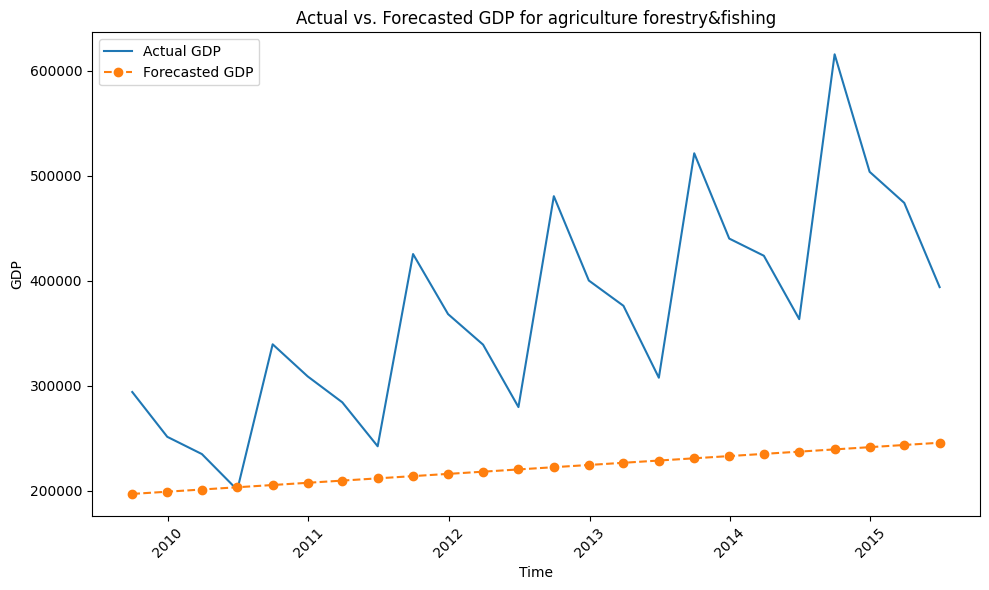

Sector: mining&quarrying
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time    GDP
54  1254268800  36226
55  1262131200  36104
56  1269907200  35498
57  1277856000  35222
58  1285804800  41018
59  1293667200  47566
60  1301443200  47621
61  1309392000  46858
62  1317340800  53019
63  1325203200  57369
64  1333065600  51147
65  1341014400  47836
66  1348963200  55985
67  1356825600  67748
68  1364601600  53419
69  1372550400  49830
70  1380499200  56595
71  1388361600  62573
72  1396137600  50724
73  1404086400  51335
74  1412035200  57363
75  1419897600  63230
76  1427673600  54804
77  1435622400  52781
Forecasted GDP:
[30778.26806999 31279.15382606 31774.53534305 32280.9253382
 32787.31533335 33288.20108942 33783.58260641 34289.97260155
 34796.3625967  35297.24835277 35798.13410884 36304.52410399
 36810.91409913 37311.7998552  37807.18137219 38313.57136734
 38819.96136249 39320.84711856 39816.22863555 40322.61863069
 40829.00862584 41329.8

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


Sector: manufacturing
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  202739
55  1262131200  200105
56  1269907200  210346
57  1277856000  223931
58  1285804800  231935
59  1293667200  255939
60  1301443200  248777
61  1309392000  255896
62  1317340800  268972
63  1325203200  298844
64  1333065600  300511
65  1341014400  298014
66  1348963200  306048
67  1356825600  331609
68  1364601600  313696
69  1372550400  317223
70  1380499200  331588
71  1388361600  358400
72  1396137600  320159
73  1404086400  329211
74  1412035200  336106
75  1419897600  364563
76  1427673600  343126
77  1435622400  341149
Forecasted GDP:
[174995.8743373  177610.99618085 180197.38042173 182841.23986795
 185485.09931418 188100.22115773 190686.6053986  193330.46484483
 195974.32429105 198589.4461346  201204.56797815 203848.42742438
 206492.2868706  209107.40871415 211693.79295502 214337.65240125
 216981.51184748 219596.63369103 222183.01793

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


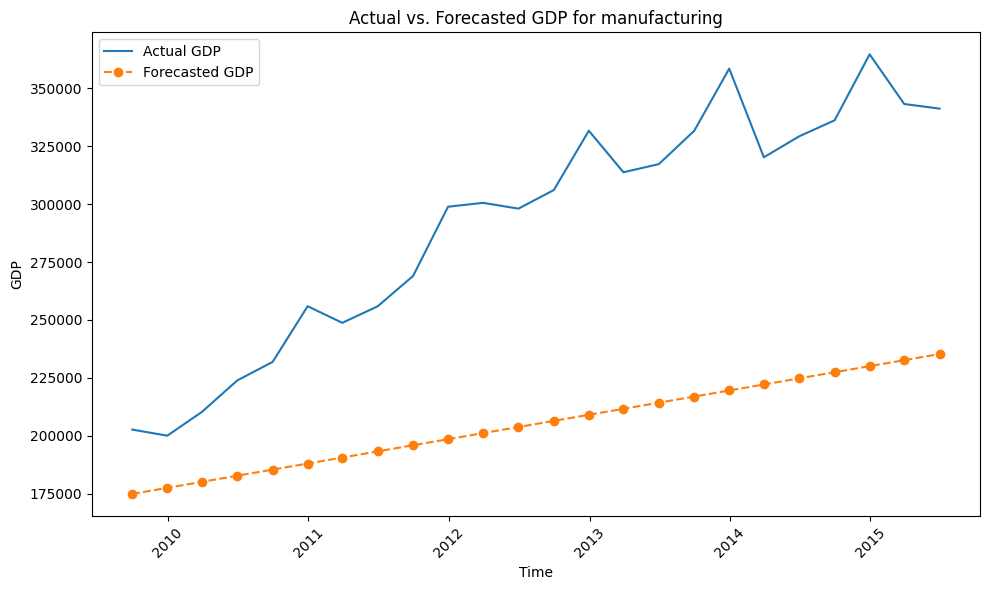

Sector: electricity gas & water supply
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time    GDP
54  1254268800  22782
55  1262131200  22986
56  1269907200  27627
57  1277856000  28610
58  1285804800  28253
59  1293667200  29394
60  1301443200  29380
61  1309392000  29452
62  1317340800  29770
63  1325203200  30959
64  1333065600  32906
65  1341014400  33361
66  1348963200  34470
67  1356825600  34933
68  1364601600  37374
69  1372550400  39536
70  1380499200  40175
71  1388361600  40047
72  1396137600  47487
73  1404086400  50529
74  1412035200  51958
75  1419897600  53075
76  1427673600  58648
77  1435622400  58576
Forecasted GDP:
[20847.01923061 21107.17270274 21364.46734551 21627.479647
 21890.49194849 22150.64542062 22407.94006339 22670.95236488
 22933.96466637 23194.1181385  23454.27161063 23717.28391213
 23980.29621362 24240.44968575 24497.74432851 24760.75663001
 25023.7689315  25283.92240363 25541.2170464  25804.22934789
 26067.241

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


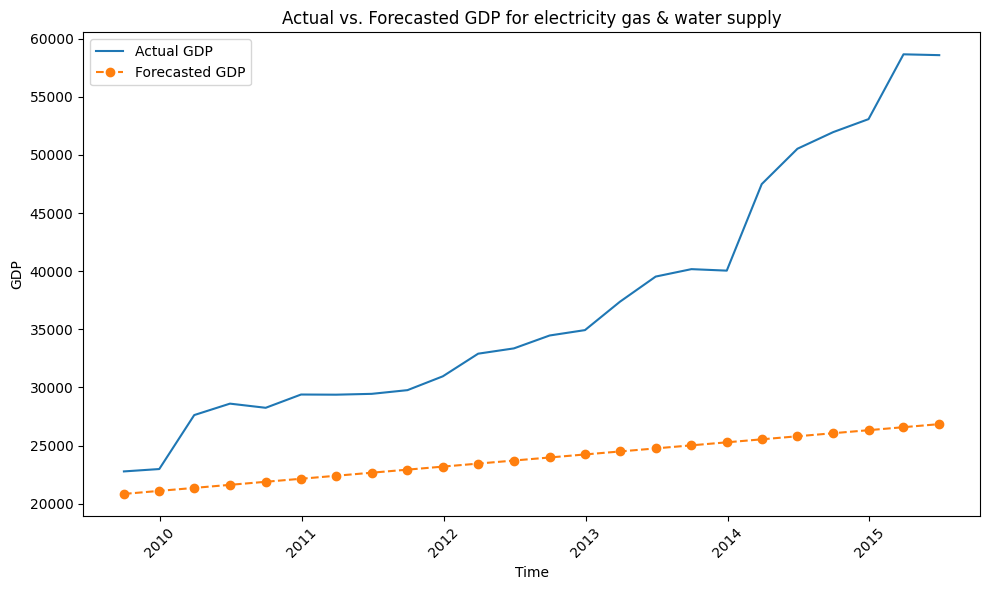

Sector: construction
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  110390
55  1262131200  116651
56  1269907200  116384
57  1277856000  120047
58  1285804800  125697
59  1293667200  138330
60  1301443200  134616
61  1309392000  134085
62  1317340800  143525
63  1325203200  159309
64  1333065600  160670
65  1341014400  164722
66  1348963200  175625
67  1356825600  188780
68  1364601600  180261
69  1372550400  177038
70  1380499200  193203
71  1388361600  209488
72  1396137600  190993
73  1404086400  197182
74  1412035200  208155
75  1419897600  222101
76  1427673600  211437
77  1435622400  214335
Forecasted GDP:
[ 90690.51686922  92310.50157764  93912.68425629  95550.47099447
  97188.25773265  98808.24244107 100410.42511972 102048.2118579
 103685.99859608 105305.98330449 106925.96801291 108563.75475109
 110201.54148926 111821.52619768 113423.70887633 115061.49561451
 116699.28235269 118319.2670611  119921.4497397

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


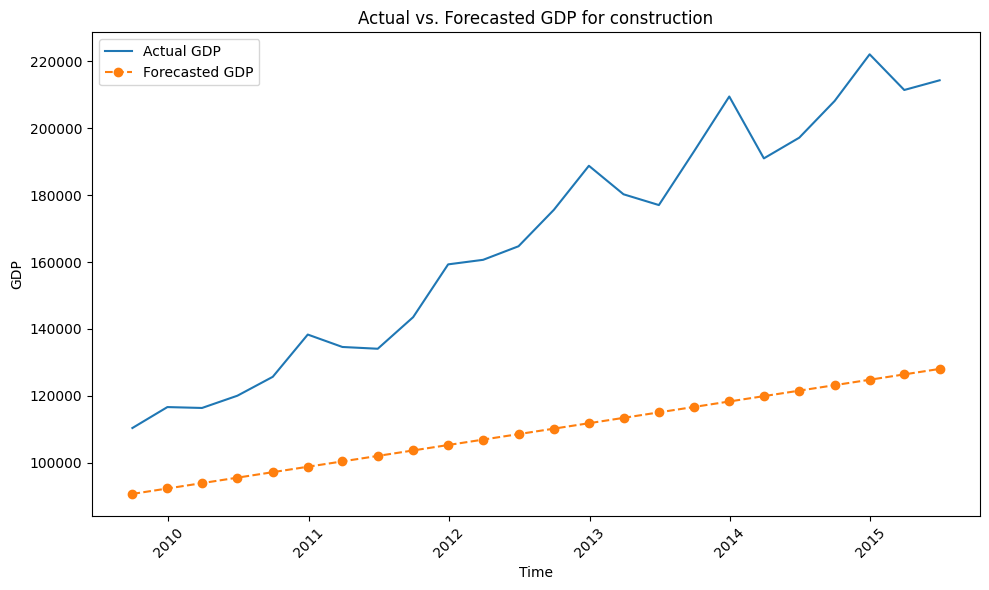

Sector: trade hotels transport and communication
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  330738
55  1262131200  327165
56  1269907200  337672
57  1277856000  355468
58  1285804800  377698
59  1293667200  410784
60  1301443200  416869
61  1309392000  425280
62  1317340800  447330
63  1325203200  490152
64  1333065600  492924
65  1341014400  499664
66  1348963200  520682
67  1356825600  559002
68  1364601600  544029
69  1372550400  564289
70  1380499200  589596
71  1388361600  626780
72  1396137600  576810
73  1404086400  620129
74  1412035200  640537
75  1419897600  672432
76  1427673600  624797
77  1435622400  661434
Forecasted GDP:
[280242.66166978 284855.77182737 289418.18846675 294081.99214255
 298745.79581836 303358.90597595 307921.32261533 312585.12629114
 317248.92996694 321862.04012453 326475.15028213 331138.95395793
 335802.75763374 340415.86779133 344978.28443071 349642.08810652
 354305.89178232 3

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


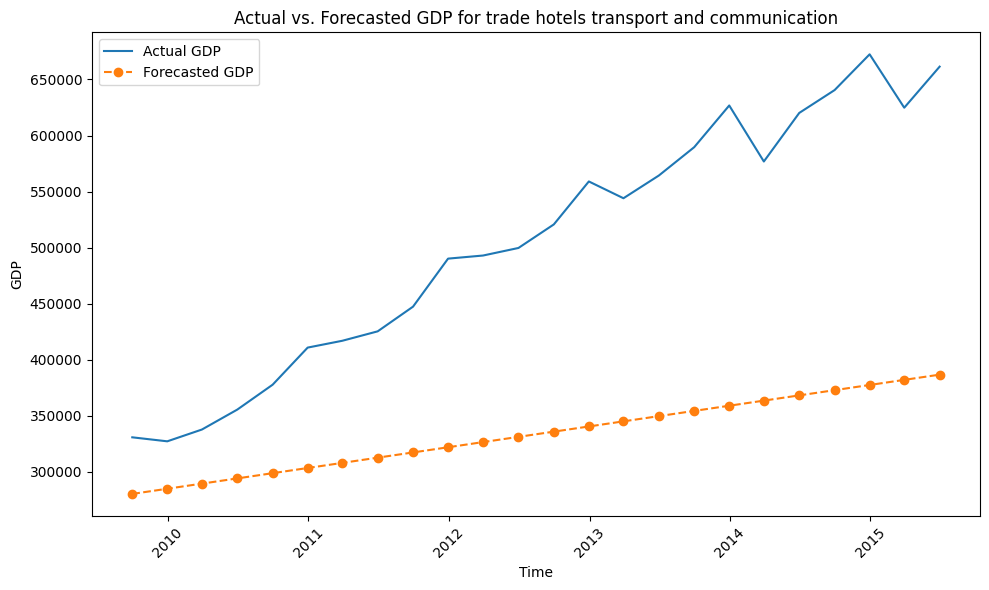

Sector: financing insurance real estate& business services
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  213657
55  1262131200  219435
56  1269907200  227211
57  1277856000  235354
58  1285804800  244168
59  1293667200  258204
60  1301443200  276202
61  1309392000  283515
62  1317340800  294757
63  1325203200  310769
64  1333065600  329595
65  1341014400  340147
66  1348963200  349152
67  1356825600  362630
68  1364601600  388606
69  1372550400  399509
70  1380499200  406551
71  1388361600  422410
72  1396137600  461234
73  1404086400  479931
74  1412035200  496457
75  1419897600  501860
76  1427673600  537198
77  1435622400  542573
Forecasted GDP:
[168617.40298952 171463.05938336 174277.44482781 177154.37217103
 180031.29951424 182876.95590808 185691.34135253 188568.26869575
 191445.19603897 194290.8524328  197136.50882663 200013.43616985
 202890.36351307 205736.0199069  208550.40535135 211427.33269457
 214304.

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


Sector: community social & personal services
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time     GDP
54  1254268800  186429
55  1262131200  195779
56  1269907200  184251
57  1277856000  224306
58  1285804800  226746
59  1293667200  247730
60  1301443200  216000
61  1309392000  257863
62  1317340800  244011
63  1325203200  297977
64  1333065600  241157
65  1341014400  296508
66  1348963200  279642
67  1356825600  337125
68  1364601600  286490
69  1372550400  351388
70  1380499200  321426
71  1388361600  382431
72  1396137600  339598
73  1404086400  395012
74  1412035200  368175
75  1419897600  420114
76  1427673600  393200
77  1435622400  455404
Forecasted GDP:
[147112.90055957 149266.83422332 151397.09828636 153574.70155081
 155752.30481526 157906.23847901 160036.50254205 162214.1058065
 164391.70907095 166545.6427347  168699.57639844 170877.17966289
 173054.78292734 175208.71659109 177338.98065413 179516.58391858
 181694.18718303 183848

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


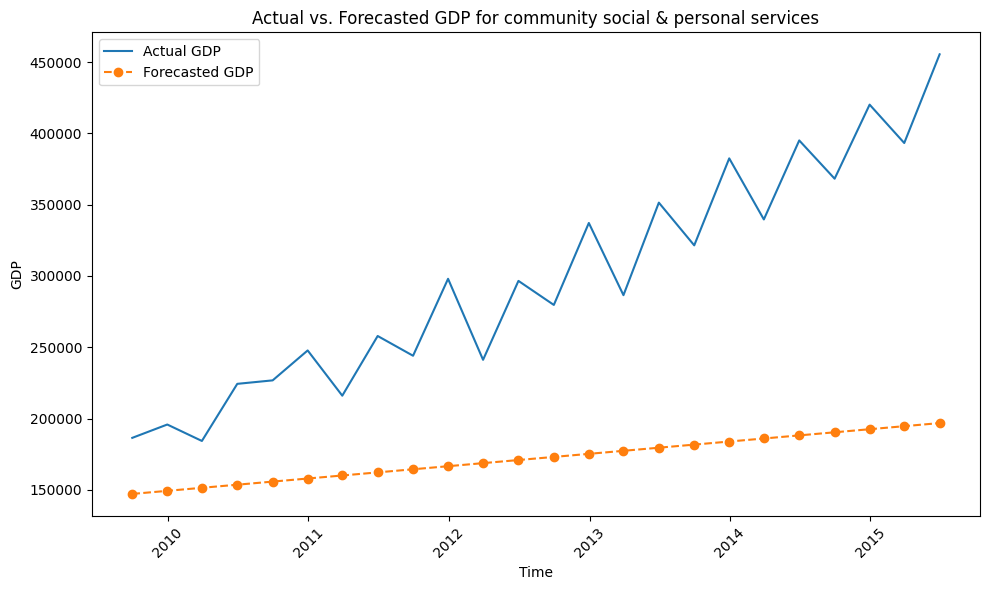

Sector: GDP at factor cost
Shape of train DataFrame: (54, 2)
Forecasted Values for Existing Data (Test Set):
          Time      GDP
54  1254268800  1396840
55  1262131200  1369417
56  1269907200  1373744
57  1277856000  1423590
58  1285804800  1614850
59  1293667200  1696719
60  1301443200  1653529
61  1309392000  1675124
62  1317340800  1906718
63  1325203200  2013488
64  1333065600  1947931
65  1341014400  1959778
66  1348963200  2202066
67  1356825600  2281917
68  1364601600  2179887
69  1372550400  2206307
70  1380499200  2460471
71  1388361600  2542212
72  1396137600  2410718
73  1404086400  2486633
74  1412035200  2774395
75  1419897600  2801061
76  1427673600  2697303
77  1435622400  2720073
Forecasted GDP:
[1110068.45693234 1126791.37878527 1143330.53226619 1160237.22249112
 1177143.91271606 1193866.83456899 1210405.98804991 1227312.67827484
 1244219.36849978 1260942.29035271 1277665.21220564 1294571.90243057
 1311478.59265551 1328201.51450844 1344740.66798936 1361647.35821429

<ipython-input-18-e3b2fcc827f4>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Time'] = pd.to_datetime(test['Time'], unit='s')


In [ ]:
# Function to perform Lasso regression and forecast
def lasso_forecast(train, test):
    # Perform Lasso regression
    model = Lasso(alpha=0.1)  # You can adjust the regularization parameter alpha as needed
    model.fit(train.drop(columns=['GDP']), train['GDP'])

    # Forecast for the test set (existing data)
    forecast_values = model.predict(test.drop(columns=['GDP']))

    return forecast_values

# Function to forecast GDP for the "agriculture forestry&fishing" sector
def forecast_existing_gdp(file_path, sector):
    # Load data from the CSV file
    data = pd.read_csv(file_path)

    # Convert the 'Time' column to a numerical representation
    data['Time'] = pd.to_datetime(data['Time']).astype(int) // 10**9

    # Sort the data by time in ascending order
    data.sort_values(by='Time', inplace=True)

    # Train-test split for existing data
    train = data[:-24]
    test = data[-24:]

    print(f"Sector: {sector}")
    print(f"Shape of train DataFrame: {train.shape}")

    # Step 2: Perform Lasso regression and hyperparameter tuning
    forecast_values = lasso_forecast(train, test)

    # Step 3: Print the sector and forecasted values for the test set (existing data)
    print(f"Forecasted Values for Existing Data (Test Set):")
    print(test[['Time', 'GDP']])
    print("Forecasted GDP:")
    print(forecast_values)

    # Convert the timestamps back to datetime objects for the test set
    test['Time'] = pd.to_datetime(test['Time'], unit='s')

    # Visualize actual vs. forecasted GDP
    plt.figure(figsize=(10, 6))
    plt.plot(test['Time'], test['GDP'], label='Actual GDP')
    plt.plot(test['Time'], forecast_values, label='Forecasted GDP', linestyle='dashed', marker='o')
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.title(f'Actual vs. Forecasted GDP for {sector}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Process each CSV file in the folder
for file_path, sector in zip(file_paths, sectors):
    forecast_existing_gdp(file_path, sector)


***Exponential Smoothing***

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: agriculture forestry&fishing
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      293878   277505.663523
2009-12-30 2009-12-30      251191   227985.731203
2010-03-30 2010-03-30      234756   223208.542823
2010-06-30 2010-06-30      200653   193286.658970
2010-09-30 2010-09-30      339335   287731.175542
2010-12-30 2010-12-30      308771   238211.243222
2011-03-30 2011-03-30      284063   233434.054842
2011-06-30 2011-06-30      242176   203512.170989
2011-09-30 2011-09-30      425335   297956.687561
2011-12-30 2011-12-30      368111   248436.755240
2012-03-30 2012-03-30      339020   243659.566860
2012-06-30 2012-06-30      279526   213737.683007
2012-09-30 2012-09-30      480461   308182.199579
2012-12-30 2012-12-30      400091   258662.267259
2013-03-30 2013-03-30      376012   253885.078879
2013-06-30 2013-06-30      307495   223963.195026
2013-09-30 2013

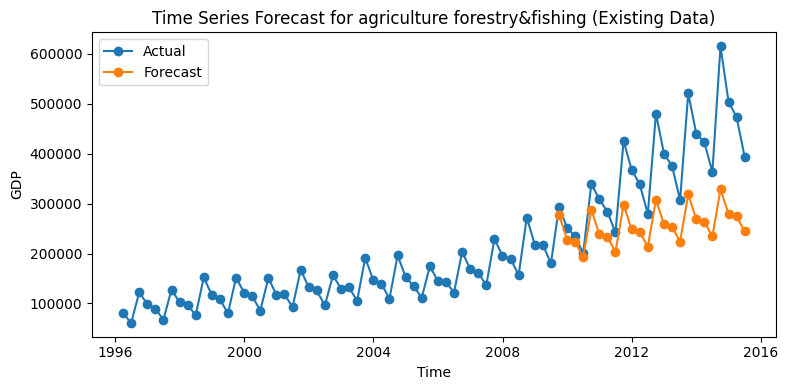

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supporte

Sector: mining&quarrying
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30       36226    37235.221854
2009-12-30 2009-12-30       36104    40101.855099
2010-03-30 2010-03-30       35498    37332.708606
2010-06-30 2010-06-30       35222    37422.966495
2010-09-30 2010-09-30       41018    40880.153265
2010-12-30 2010-12-30       47566    43746.786510
2011-03-30 2011-03-30       47621    40977.640017
2011-06-30 2011-06-30       46858    41067.897906
2011-09-30 2011-09-30       53019    44525.084675
2011-12-30 2011-12-30       57369    47391.717921
2012-03-30 2012-03-30       51147    44622.571427
2012-06-30 2012-06-30       47836    44712.829316
2012-09-30 2012-09-30       55985    48170.016086
2012-12-30 2012-12-30       67748    51036.649332
2013-03-30 2013-03-30       53419    48267.502838
2013-06-30 2013-06-30       49830    48357.760727
2013-09-30 2013-09-30      

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: manufacturing
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      202739   216867.178500
2009-12-30 2009-12-30      200105   226966.418676
2010-03-30 2010-03-30      210346   226512.230406
2010-06-30 2010-06-30      223931   234243.126452
2010-09-30 2010-09-30      231935   241620.396096
2010-12-30 2010-12-30      255939   251719.636271
2011-03-30 2011-03-30      248777   251265.448001
2011-06-30 2011-06-30      255896   258996.344048
2011-09-30 2011-09-30      268972   266373.613691
2011-12-30 2011-12-30      298844   276472.853867
2012-03-30 2012-03-30      300511   276018.665597
2012-06-30 2012-06-30      298014   283749.561643
2012-09-30 2012-09-30      306048   291126.831286
2012-12-30 2012-12-30      331609   301226.071462
2013-03-30 2013-03-30      313696   300771.883192
2013-06-30 2013-06-30      317223   308502.779238
2013-09-30 2013-09-30      331

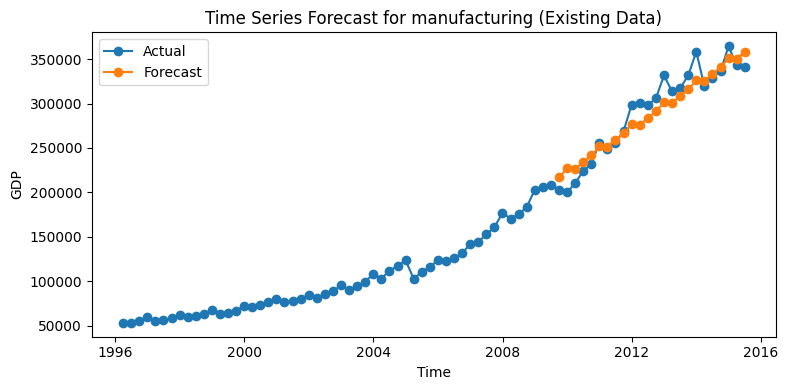

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supporte

Sector: electricity gas & water supply
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30       22782    22953.657537
2009-12-30 2009-12-30       22986    23340.732540
2010-03-30 2010-03-30       27627    24516.487798
2010-06-30 2010-06-30       28610    24411.590448
2010-09-30 2010-09-30       28253    24809.164322
2010-12-30 2010-12-30       29394    25196.239324
2011-03-30 2011-03-30       29380    26371.994582
2011-06-30 2011-06-30       29452    26267.097232
2011-09-30 2011-09-30       29770    26664.671106
2011-12-30 2011-12-30       30959    27051.746109
2012-03-30 2012-03-30       32906    28227.501366
2012-06-30 2012-06-30       33361    28122.604017
2012-09-30 2012-09-30       34470    28520.177890
2012-12-30 2012-12-30       34933    28907.252893
2013-03-30 2013-03-30       37374    30083.008150
2013-06-30 2013-06-30       39536    29978.110801
2013-09-30 20

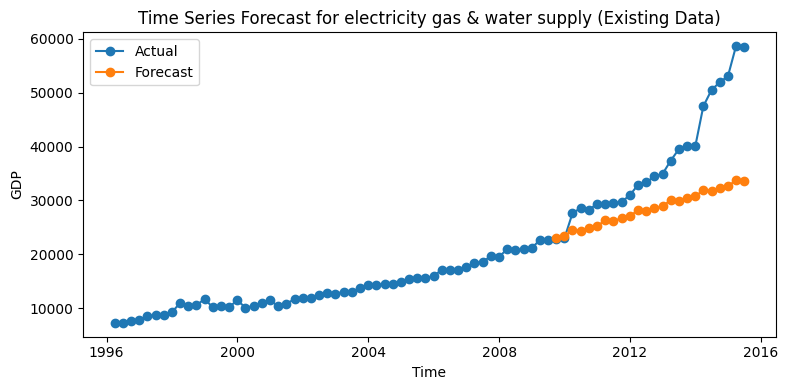

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supporte

Sector: construction
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      110390   119077.169461
2009-12-30 2009-12-30      116651   124487.250544
2010-03-30 2010-03-30      116384   128293.236542
2010-06-30 2010-06-30      120047   131713.135320
2010-09-30 2010-09-30      125697   137519.866630
2010-12-30 2010-12-30      138330   142929.947713
2011-03-30 2011-03-30      134616   146735.933711
2011-06-30 2011-06-30      134085   150155.832489
2011-09-30 2011-09-30      143525   155962.563799
2011-12-30 2011-12-30      159309   161372.644882
2012-03-30 2012-03-30      160670   165178.630880
2012-06-30 2012-06-30      164722   168598.529658
2012-09-30 2012-09-30      175625   174405.260969
2012-12-30 2012-12-30      188780   179815.342051
2013-03-30 2013-03-30      180261   183621.328050
2013-06-30 2013-06-30      177038   187041.226827
2013-09-30 2013-09-30      1932

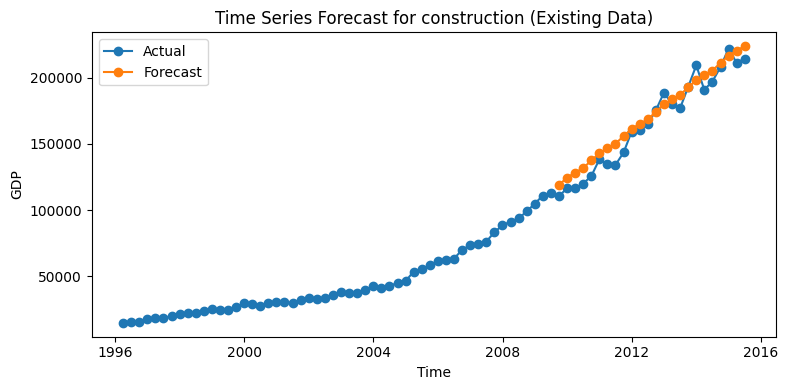

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: trade hotels transport and communication
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      330738   356575.329825
2009-12-30 2009-12-30      327165   382085.425174
2010-03-30 2010-03-30      337672   376807.309462
2010-06-30 2010-06-30      355468   383369.168246
2010-09-30 2010-09-30      377698   410193.445733
2010-12-30 2010-12-30      410784   435703.541081
2011-03-30 2011-03-30      416869   430425.425370
2011-06-30 2011-06-30      425280   436987.284153
2011-09-30 2011-09-30      447330   463811.561640
2011-12-30 2011-12-30      490152   489321.656988
2012-03-30 2012-03-30      492924   484043.541277
2012-06-30 2012-06-30      499664   490605.400060
2012-09-30 2012-09-30      520682   517429.677547
2012-12-30 2012-12-30      559002   542939.772896
2013-03-30 2013-03-30      544029   537661.657184
2013-06-30 2013-06-30      564289   544223.515967
201

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: financing insurance real estate& business services
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      213657   221816.112152
2009-12-30 2009-12-30      219435   233601.243805
2010-03-30 2010-03-30      227211   242576.288355
2010-06-30 2010-06-30      235354   252304.545377
2010-09-30 2010-09-30      244168   263691.096047
2010-12-30 2010-12-30      258204   275476.227700
2011-03-30 2011-03-30      276202   284451.272250
2011-06-30 2011-06-30      283515   294179.529272
2011-09-30 2011-09-30      294757   305566.079942
2011-12-30 2011-12-30      310769   317351.211594
2012-03-30 2012-03-30      329595   326326.256144
2012-06-30 2012-06-30      340147   336054.513166
2012-09-30 2012-09-30      349152   347441.063836
2012-12-30 2012-12-30      362630   359226.195489
2013-03-30 2013-03-30      388606   368201.240039
2013-06-30 2013-06-30      399509   377929.

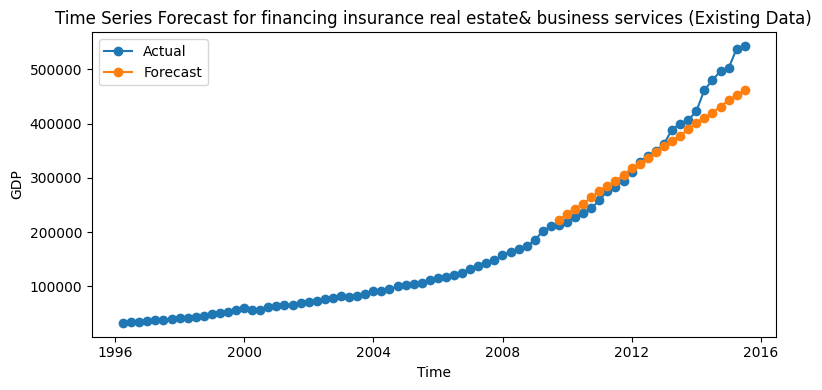

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: community social & personal services
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30      186429   169285.485255
2009-12-30 2009-12-30      195779   194704.333672
2010-03-30 2010-03-30      184251   176947.841532
2010-06-30 2010-06-30      224306   190727.659763
2010-09-30 2010-09-30      226746   192436.528898
2010-12-30 2010-12-30      247730   217855.377316
2011-03-30 2011-03-30      216000   200098.885176
2011-06-30 2011-06-30      257863   213878.703407
2011-09-30 2011-09-30      244011   215587.572542
2011-12-30 2011-12-30      297977   241006.420960
2012-03-30 2012-03-30      241157   223249.928820
2012-06-30 2012-06-30      296508   237029.747051
2012-09-30 2012-09-30      279642   238738.616186
2012-12-30 2012-12-30      337125   264157.464604
2013-03-30 2013-03-30      286490   246400.972463
2013-06-30 2013-06-30      351388   260180.790694
2013-09

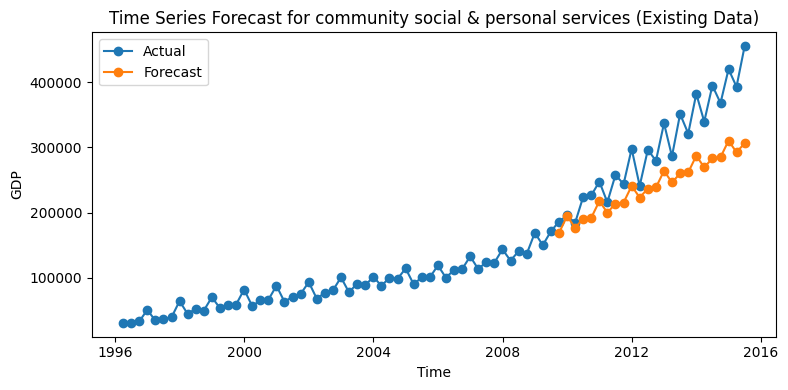

<ipython-input-24-a6e505ced782>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GDP'].fillna(train['GDP'].mean(), inplace=True)
<ipython-input-24-a6e505ced782>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GDP'].fillna(test['GDP'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Op

Sector: GDP at factor cost
Forecasted Values for Existing Data (Test Set):
                 Time  Actual GDP  Forecasted GDP
Time                                             
2009-09-30 2009-09-30     1396840    1.434357e+06
2009-12-30 2009-12-30     1369417    1.479687e+06
2010-03-30 2010-03-30     1373744    1.466048e+06
2010-06-30 2010-06-30     1423590    1.476140e+06
2010-09-30 2010-09-30     1614850    1.637528e+06
2010-12-30 2010-12-30     1696719    1.682858e+06
2011-03-30 2011-03-30     1653529    1.669218e+06
2011-06-30 2011-06-30     1675124    1.679310e+06
2011-09-30 2011-09-30     1906718    1.840698e+06
2011-12-30 2011-12-30     2013488    1.886028e+06
2012-03-30 2012-03-30     1947931    1.872389e+06
2012-06-30 2012-06-30     1959778    1.882481e+06
2012-09-30 2012-09-30     2202066    2.043869e+06
2012-12-30 2012-12-30     2281917    2.089198e+06
2013-03-30 2013-03-30     2179887    2.075559e+06
2013-06-30 2013-06-30     2206307    2.085651e+06
2013-09-30 2013-09-30    

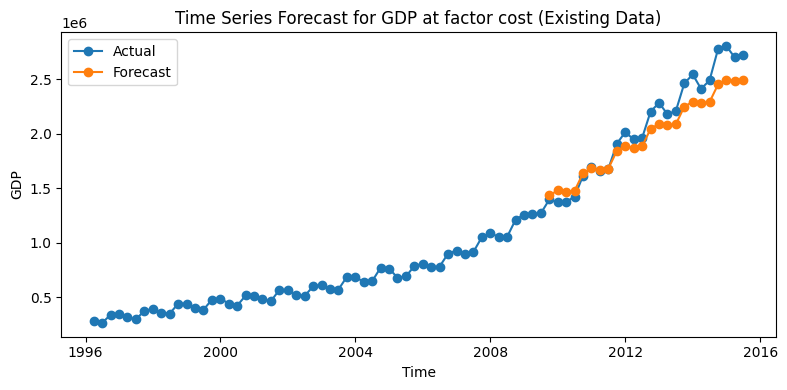

In [24]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    return df

def split_train_test(df, train_ratio=0.7):
    num_records = len(df)
    num_train_records = int(train_ratio * num_records)
    train = df[:num_train_records]
    test = df[num_train_records:]
    return train, test
def exponential_smoothing_forecast(train, test):
    # Fill missing values with the mean of the training data
    train['GDP'].fillna(train['GDP'].mean(), inplace=True)
    test['GDP'].fillna(test['GDP'].mean(), inplace=True)

    # Perform Exponential Smoothing
    model = ExponentialSmoothing(train['GDP'], trend='add', seasonal='add', seasonal_periods=4)
    model_fit = model.fit()

    # Forecast for the test set
    n_periods = len(test)
    forecast_values = model_fit.forecast(steps=n_periods)

    # Set the index for the forecast_values DataFrame to match the test set
    forecast_values.index = test.index

    # Calculate the RMSE for the test set
    mse = mean_squared_error(test['GDP'], forecast_values)
    rmse = np.sqrt(mse)

    return forecast_values, rmse
def forecast_existing_gdp(file_path, sector):
    # Read the processed data
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    # Calculate the number of records for the training set (80% of total records)
    num_records = len(df)
    num_train_records = int(0.7 * num_records)

    # Split the data into train and test sets
    train = df[:num_train_records]
    test = df[num_train_records:]

    # Perform Exponential Smoothing and get forecasted values and RMSE
    forecast_values, rmse = exponential_smoothing_forecast(train, test)

    # Print the sector and forecasted values for the test set (existing data)
    print(f"Sector: {sector}")
    print("Forecasted Values for Existing Data (Test Set):")
    forecast_df = pd.DataFrame({'Time': test.index, 'Actual GDP': test['GDP'], 'Forecasted GDP': forecast_values})
    print(forecast_df)
    print()

    # Print the sector and RMSE for the test set (existing data)
    print(f"Sector: {sector}")
    print(f"Root Mean Squared Error (RMSE) for Existing Data (Test Set): {rmse}")
    print()

    # Plot the actual data and forecast for the test set (existing data)
    plt.figure(figsize=(8, 4))
    plt.plot(df.index, df['GDP'], label='Actual', linestyle='-', marker='o')
    plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='-', marker='o')
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.title(f'Time Series Forecast for {sector} (Existing Data)')
    plt.legend()
    plt.tight_layout()
    plt.show()
# Process each CSV file in the folder
for file_path, sector in zip(file_paths, sectors):
    forecast_existing_gdp(file_path, sector)
